In [1]:
%matplotlib notebook
import astropy.table as table
import numpy as np
import matplotlib.pyplot as plt
import observesim.db.peewee.targetdb as targetdb
import peewee
import healpy
import fitsio

## Introduction

This notebook looks at the currently submitted targets in the db and assesses their coverage, and the implications for how the sky would need to be covered to get to all the targets with the required cadence. The calculation is approximate, in the sense that it does not work out an actual tiling of the field.

We use a healpix pixelization of the sky to express the number densities of targets, and within which to calculate the numbers of epochs. NSIDE=32 corresponds to pixels with an area of 3.357 square degrees.

Target list as of 2018-03-05.

In [2]:
nside = 32

# Retrieving the data

First, we will grab the target data from the database.

In [3]:
targetdb.database.connect_from_config('local')

In [4]:
ntargets = targetdb.Target.select(targetdb.Target.ra, targetdb.Target.dec).count()

In [5]:
targets = (targetdb.Target
           .select(targetdb.Target.ra,
                   targetdb.Target.dec,
                   targetdb.TargetType.label,
                   targetdb.Program.label,
                   targetdb.Spectrograph.label,
                   targetdb.TargetCadence.n_epochs,
                   targetdb.TargetCadence.n_exp_per_epoch,
                   targetdb.Survey.label)
           .join(targetdb.TargetCadence)
           .switch(targetdb.Target).join(targetdb.TargetType)
           .switch(targetdb.Target).join(targetdb.Spectrograph)
           .switch(targetdb.Target).join(targetdb.Program).join(targetdb.Survey)
           .tuples()
          )

In [6]:
ra = np.zeros(ntargets, dtype=np.float64)
dec = np.zeros(ntargets, dtype=np.float64)
n_epochs = np.zeros(ntargets, dtype=np.int32)
n_exp_per_epoch = np.zeros(ntargets, dtype=np.int32)
program = []
spectrograph = []
survey = []
target_type = []

In [7]:
for (indx, t) in zip(np.arange(ntargets), targets.iterator()):
    ra[indx] = t[0]
    dec[indx] = t[1]
    target_type.append(t[2])
    program.append(t[3])
    spectrograph.append(t[4])
    n_epochs[indx] = t[5]
    n_exp_per_epoch[indx] = t[6]
    survey.append(t[7])

We calculate the healpix pixel on which we are basing our decisions.

In [8]:
hpix = healpy.pixelfunc.ang2pix(nside, ra, dec, lonlat=True)

In [9]:
columns = [ra, dec, hpix, survey, program, spectrograph, target_type, n_epochs, n_exp_per_epoch]
names = ('ra', 'dec', 'hpix', 'survey', 'program', 'spectrograph', 'target_type', 'n_epochs', 'n_exp_per_epoch')
tcat = table.Table(columns, names=names)

We write out to a FITS file for temporary convenience.

In [10]:
tcat.write('targets.fits', overwrite=True)

## Program maps 

Now we will look at how the programs cover the sky.

In [11]:
tt = fitsio.read('targets.fits')
tcat = table.Table(tt)

The hackery below allows us to map programs to spectrographs (APOGEE or optical) and assigns an index to each program.

In [12]:
programs = ['Disco', 'Dust', 'ATLaS_RV', 'ATLaS_TESS',
            'WD', 'SOE_OPT', 'SOE_IR', 'SPIDERS_AGN',
            'ReSpeQ_WIDEA', 'ReSpeQ_WIDEB', 'ReSpeQ_MED',
            'ReSpeQ_RM']
oas = ['apogee', 'apogee', 'apogee', 'apogee', 'optical', 'optical',
      'apogee', 'optical', 'optical', 'optical', 'optical', 'optical']
pindex = dict()
indexp = dict()
programoa = dict()
for indx, program, oa in zip(range(len(programs)), programs, oas):
    pindex[program] = indx
    programoa[program] = oa
    indexp[indx] = program

Now we just map which program is in which area of sky.

In [53]:
pmap = np.zeros((healpy.nside2npix(nside), len(pindex)), dtype=np.int32)
pmap_nexp = np.zeros((healpy.nside2npix(nside), len(pindex)), dtype=np.int32)
for h, p, ne, npe in zip(tcat['hpix'], tcat['program'], tcat['n_epochs'], tcat['n_exp_per_epoch']):
    if(ne > pmap[h, pindex[p]]):
        pmap[h, pindex[p]] = ne
    if(npe > pmap_nexp[h, pindex[p]]):
        pmap_nexp[h, pindex[p]] = npe

<IPython.core.display.Javascript object>


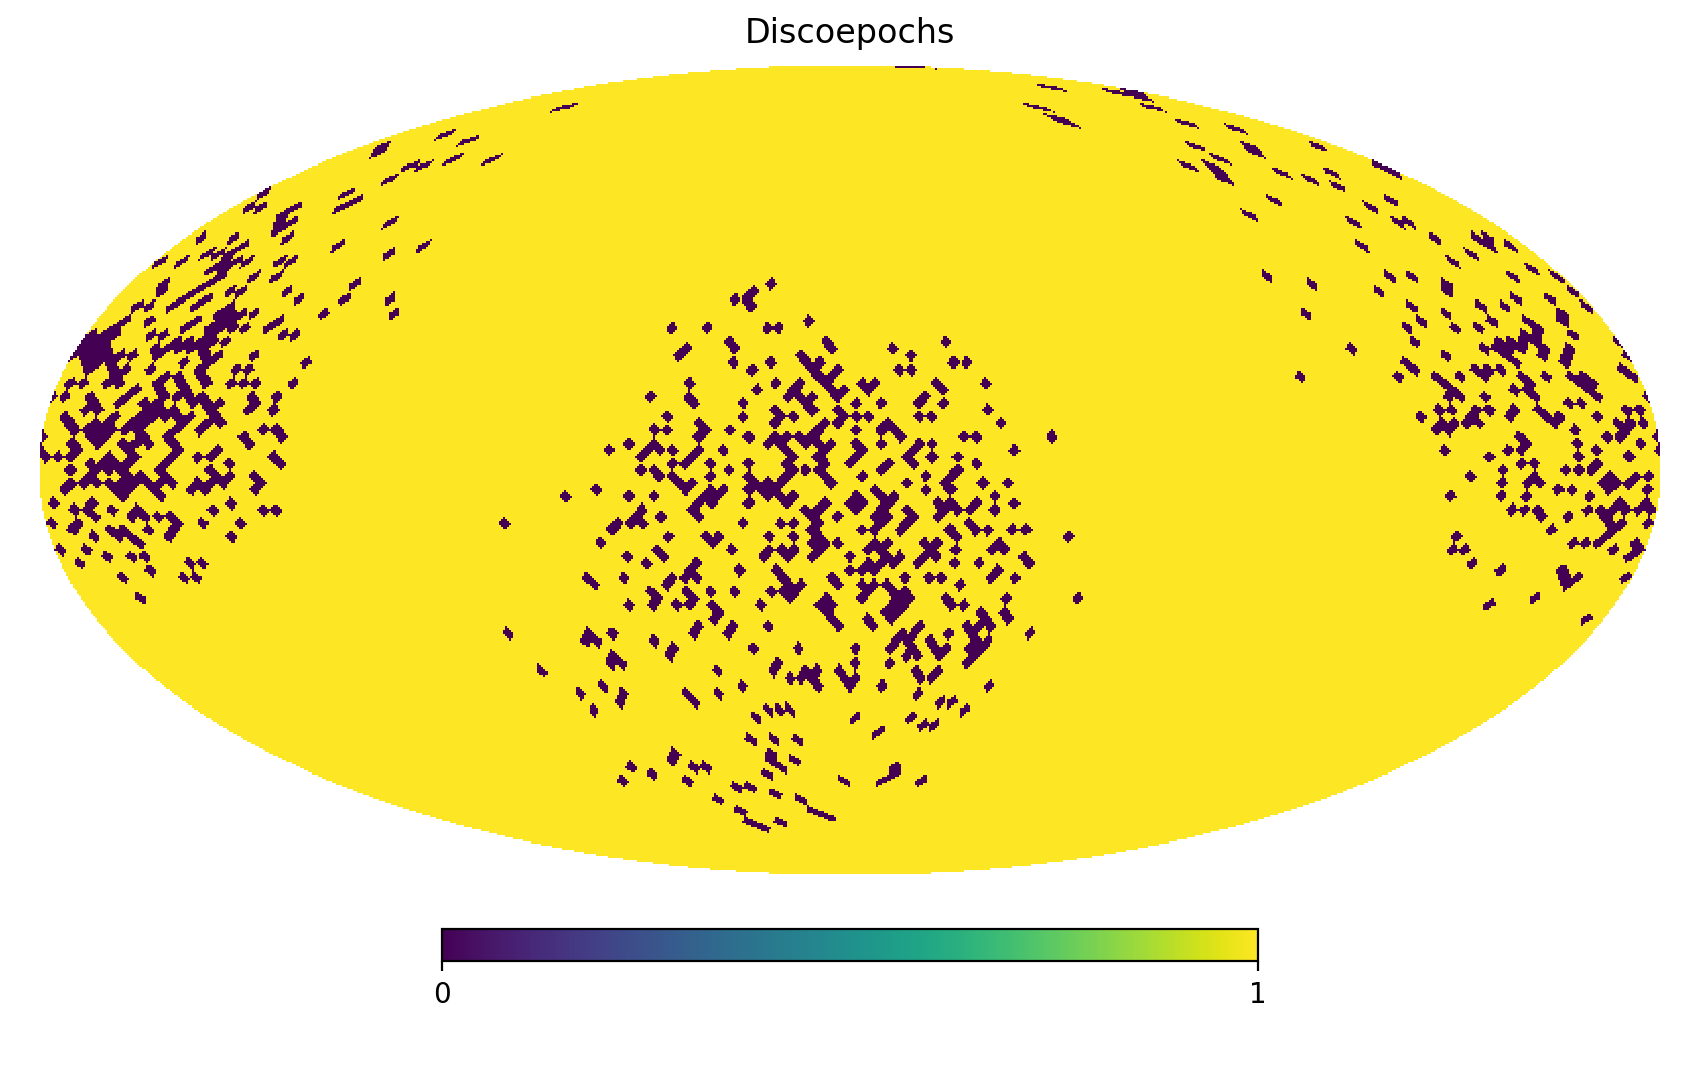

<IPython.core.display.Javascript object>


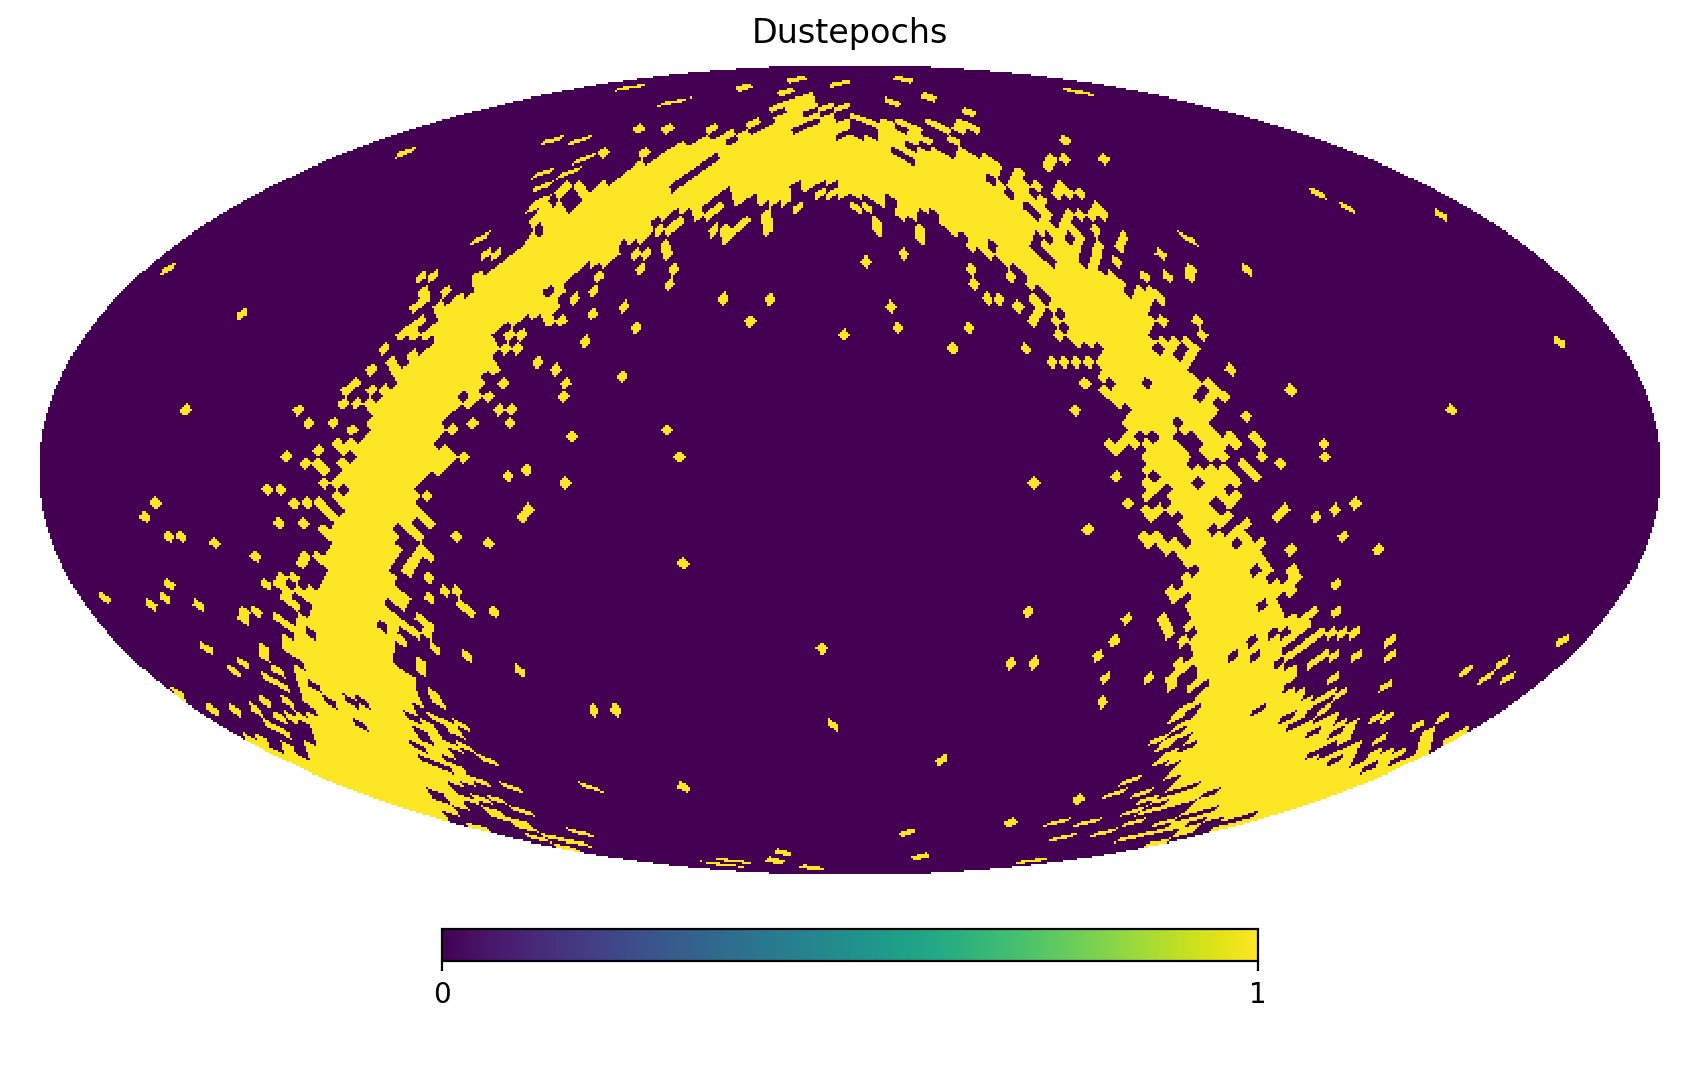

<IPython.core.display.Javascript object>


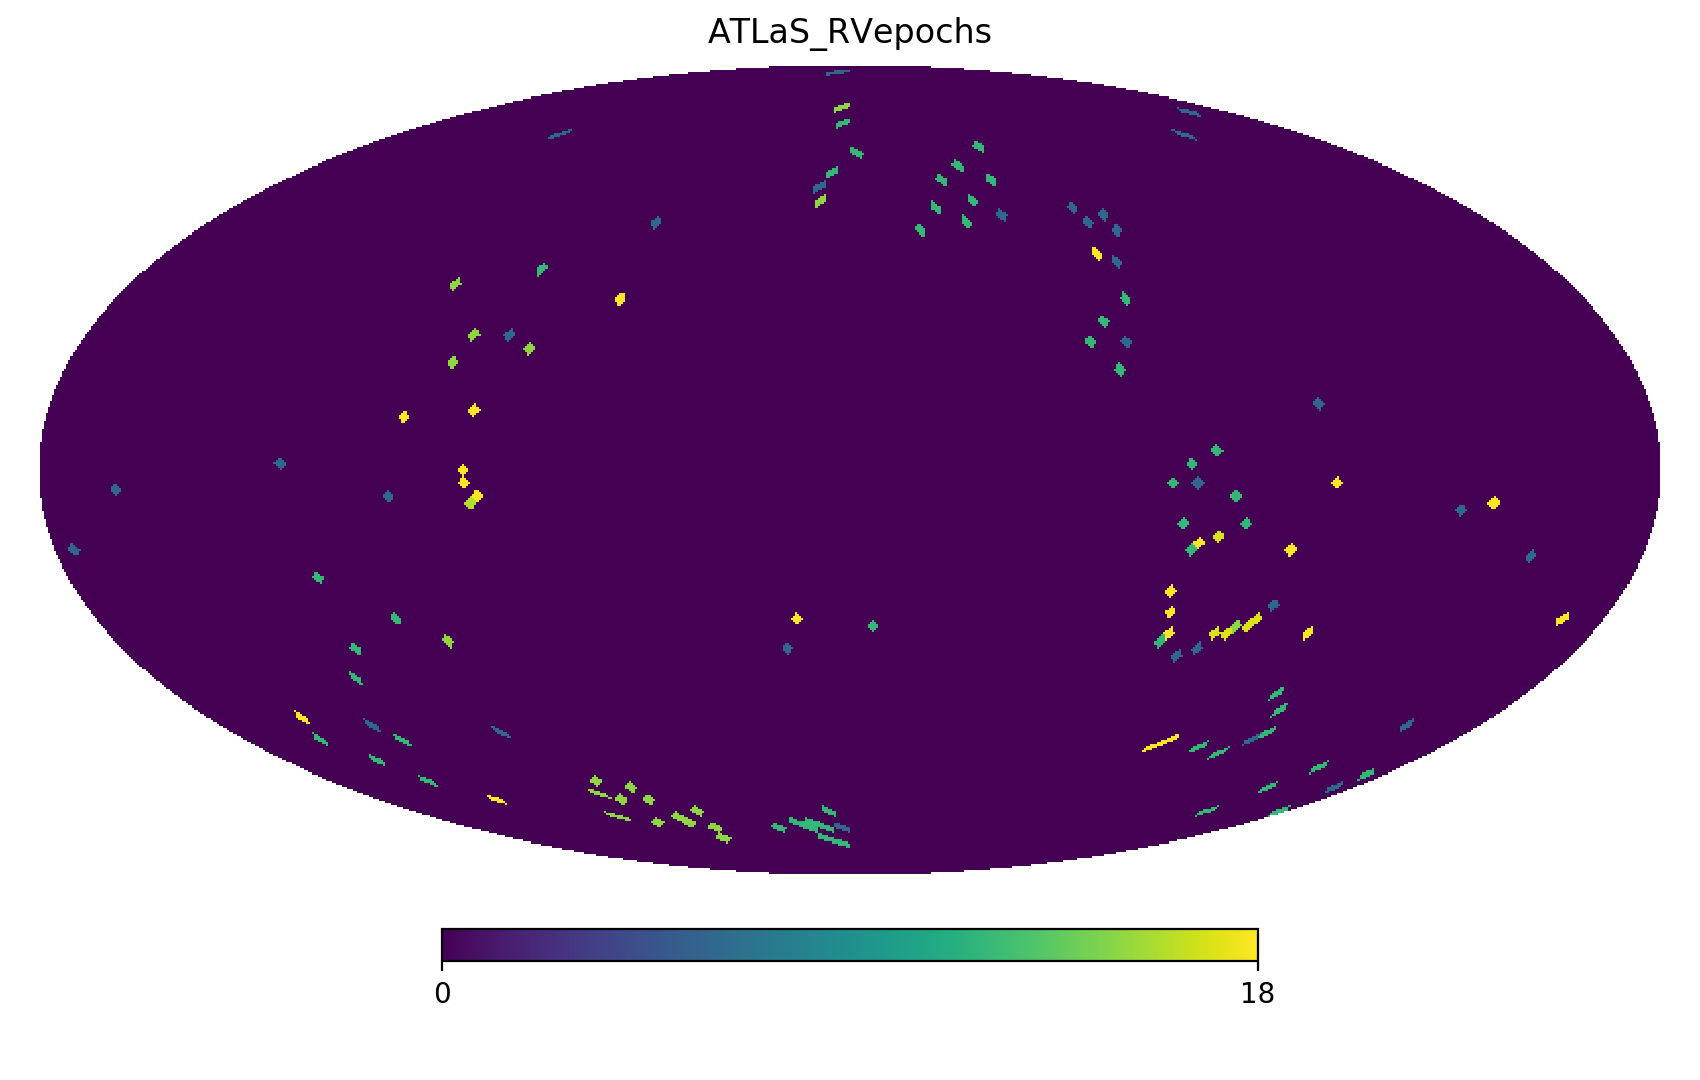

<IPython.core.display.Javascript object>


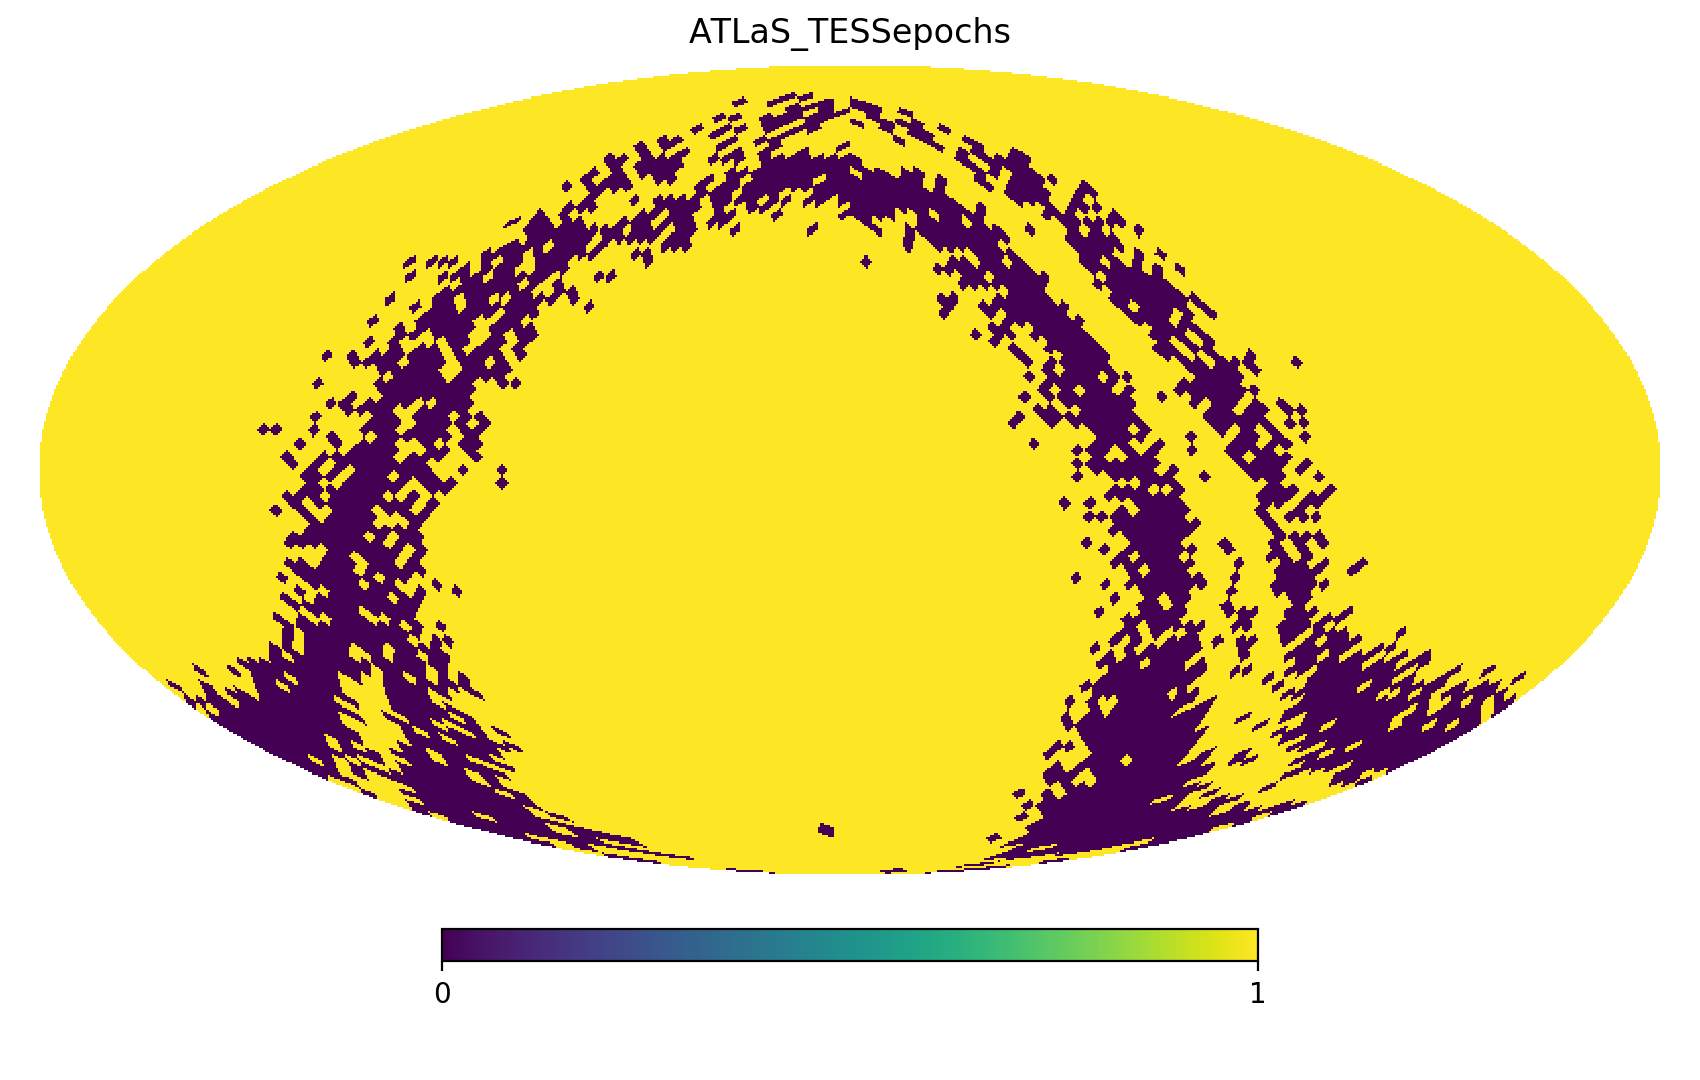

<IPython.core.display.Javascript object>


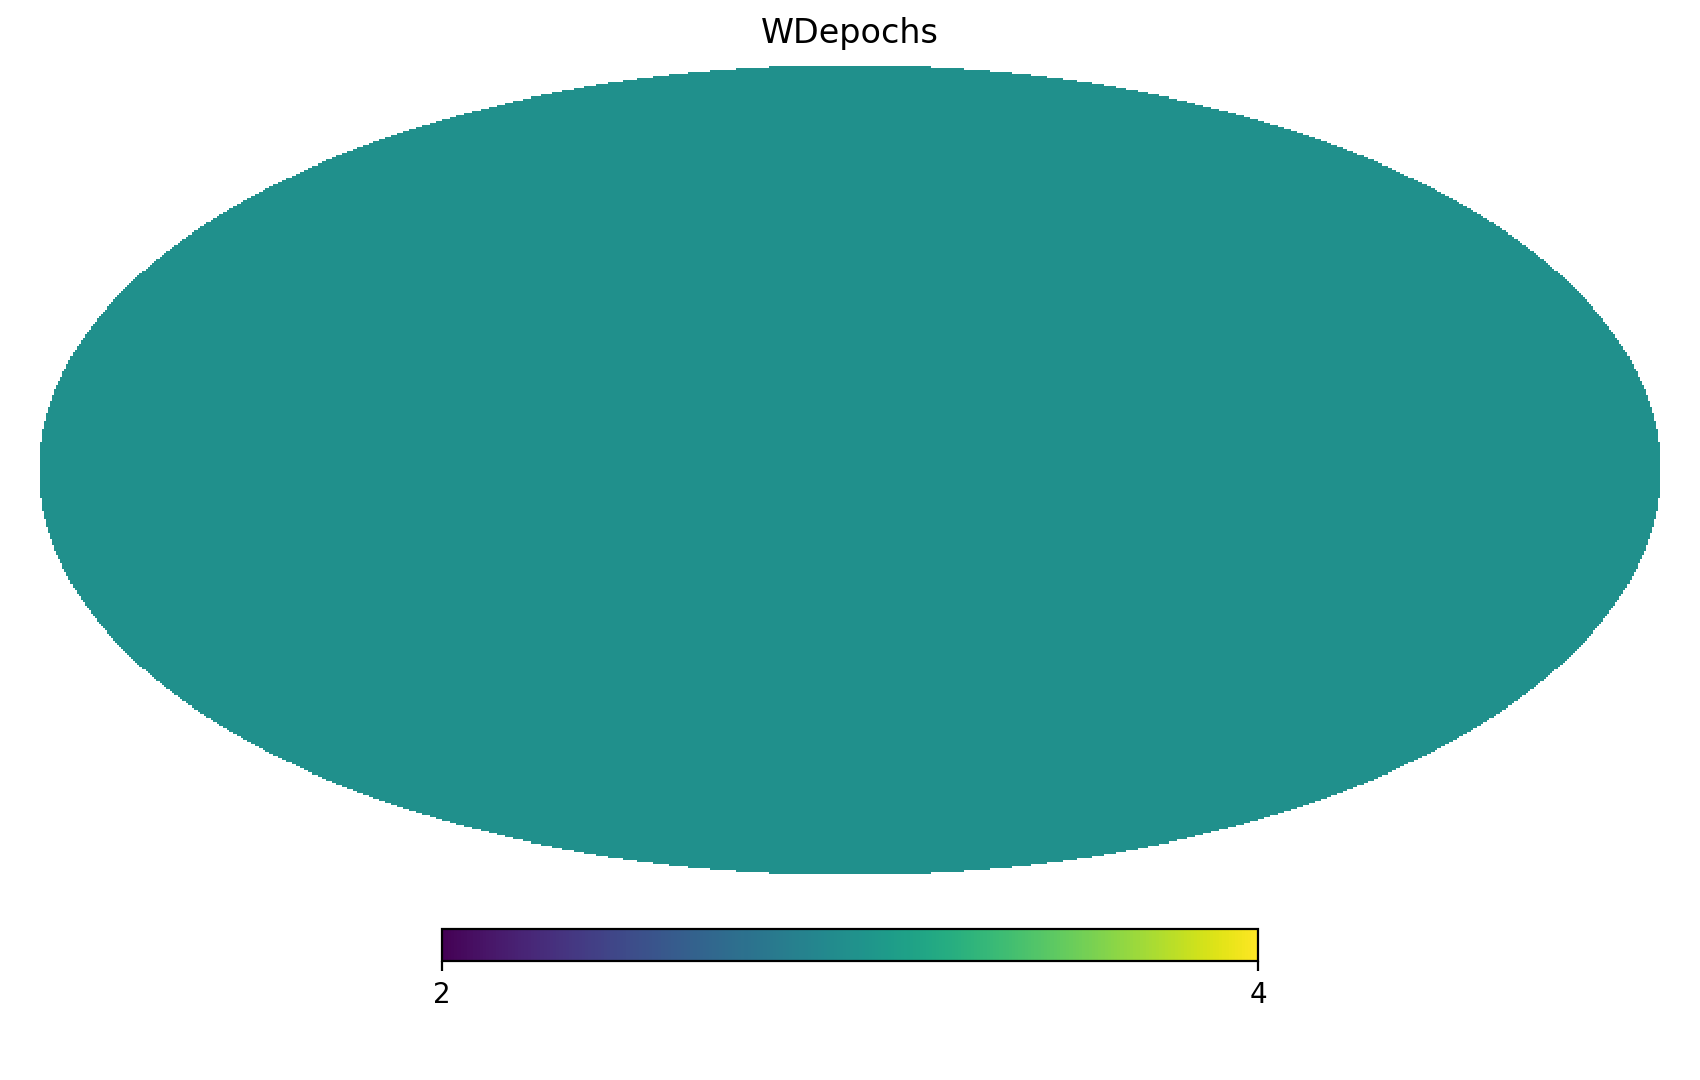

<IPython.core.display.Javascript object>


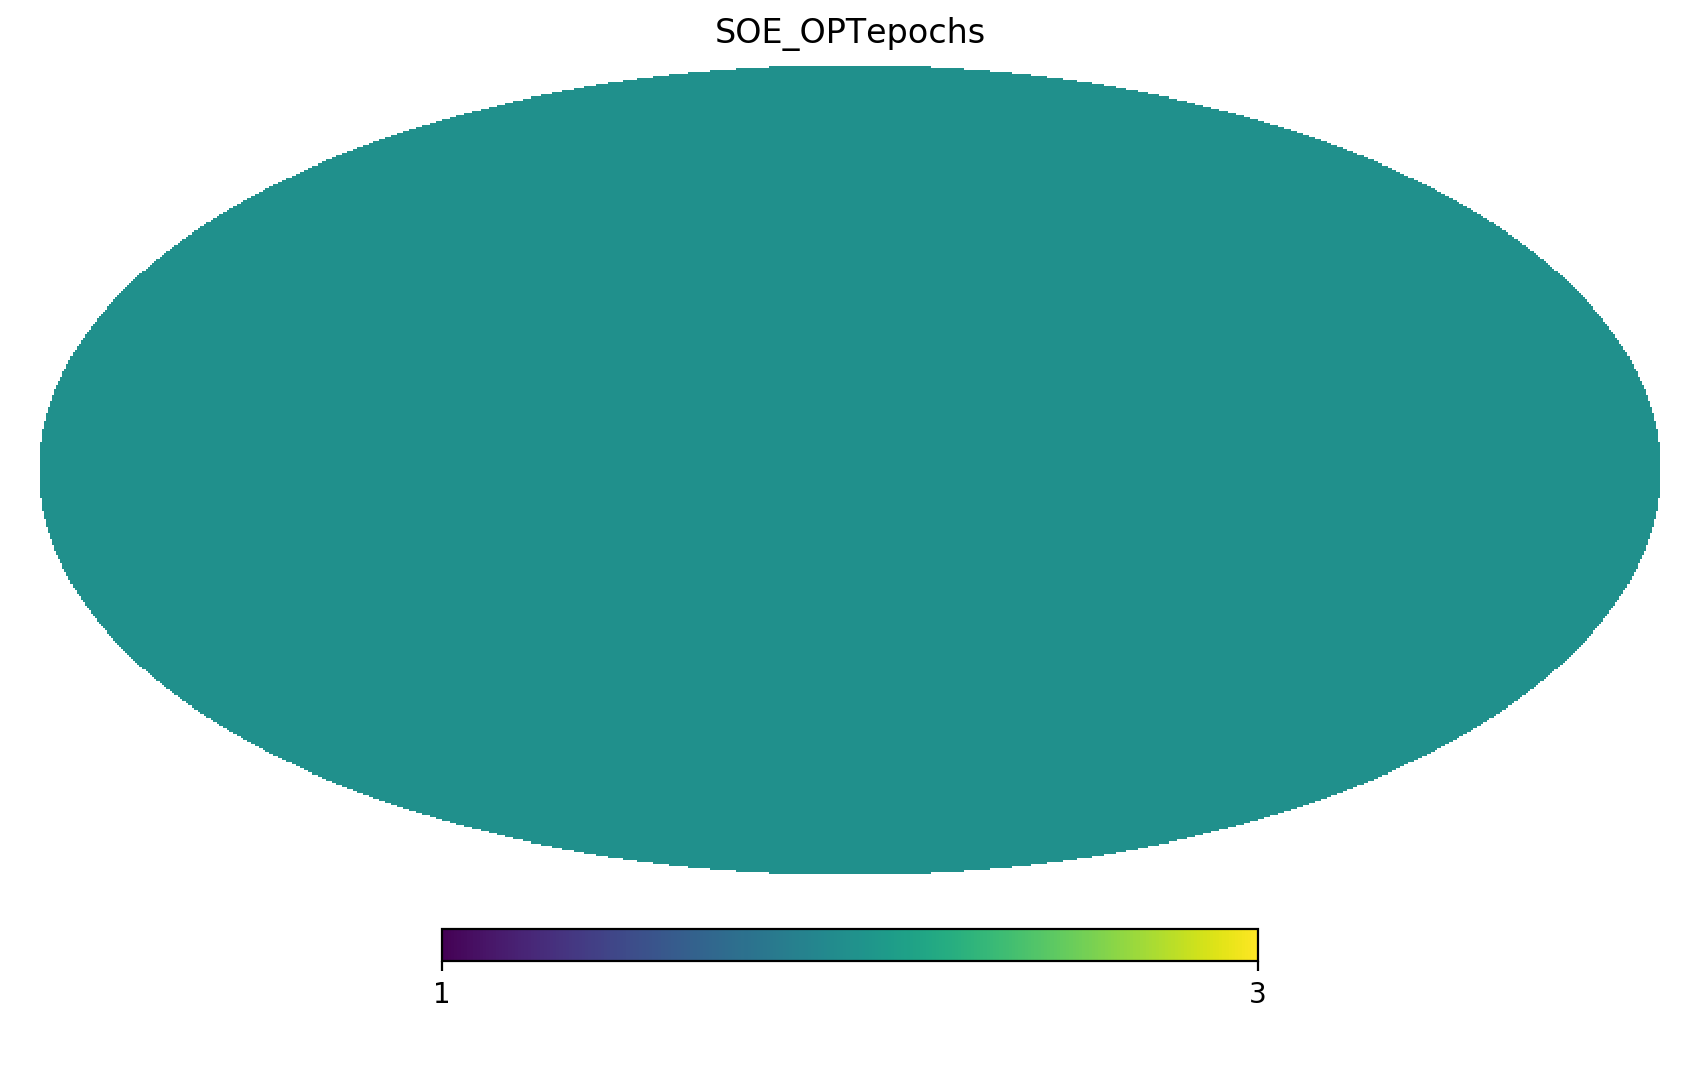

<IPython.core.display.Javascript object>


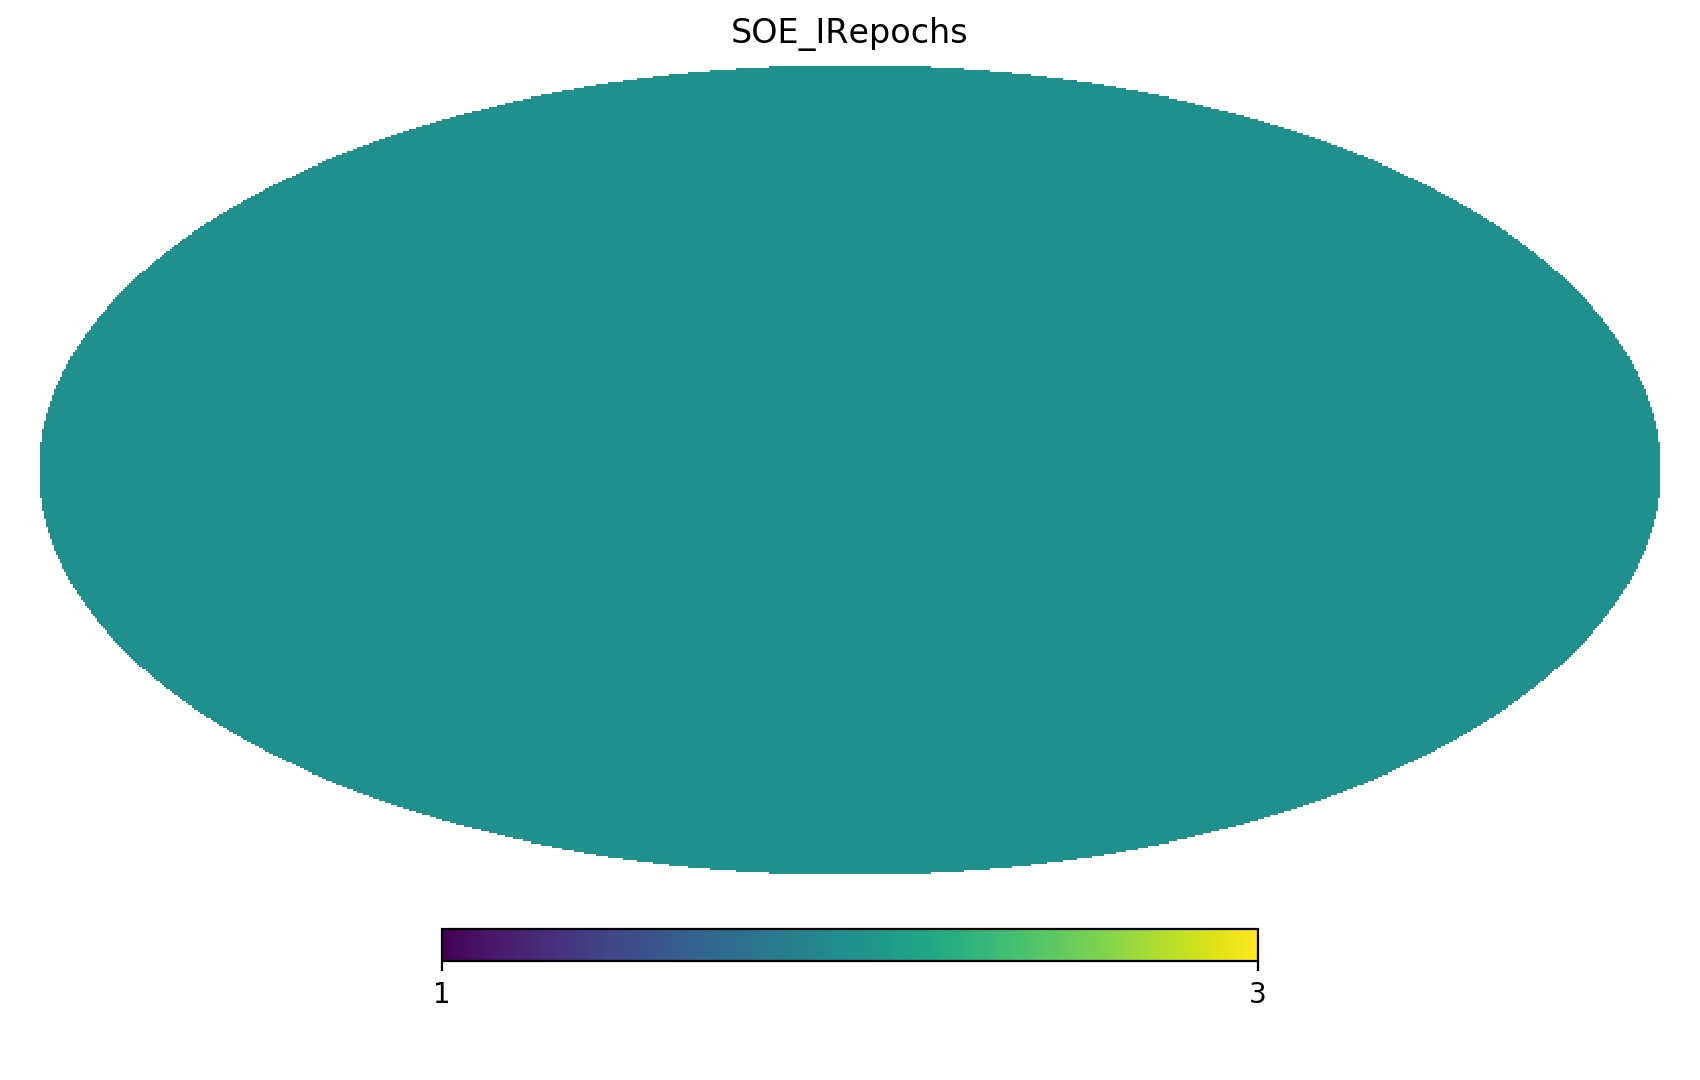

<IPython.core.display.Javascript object>


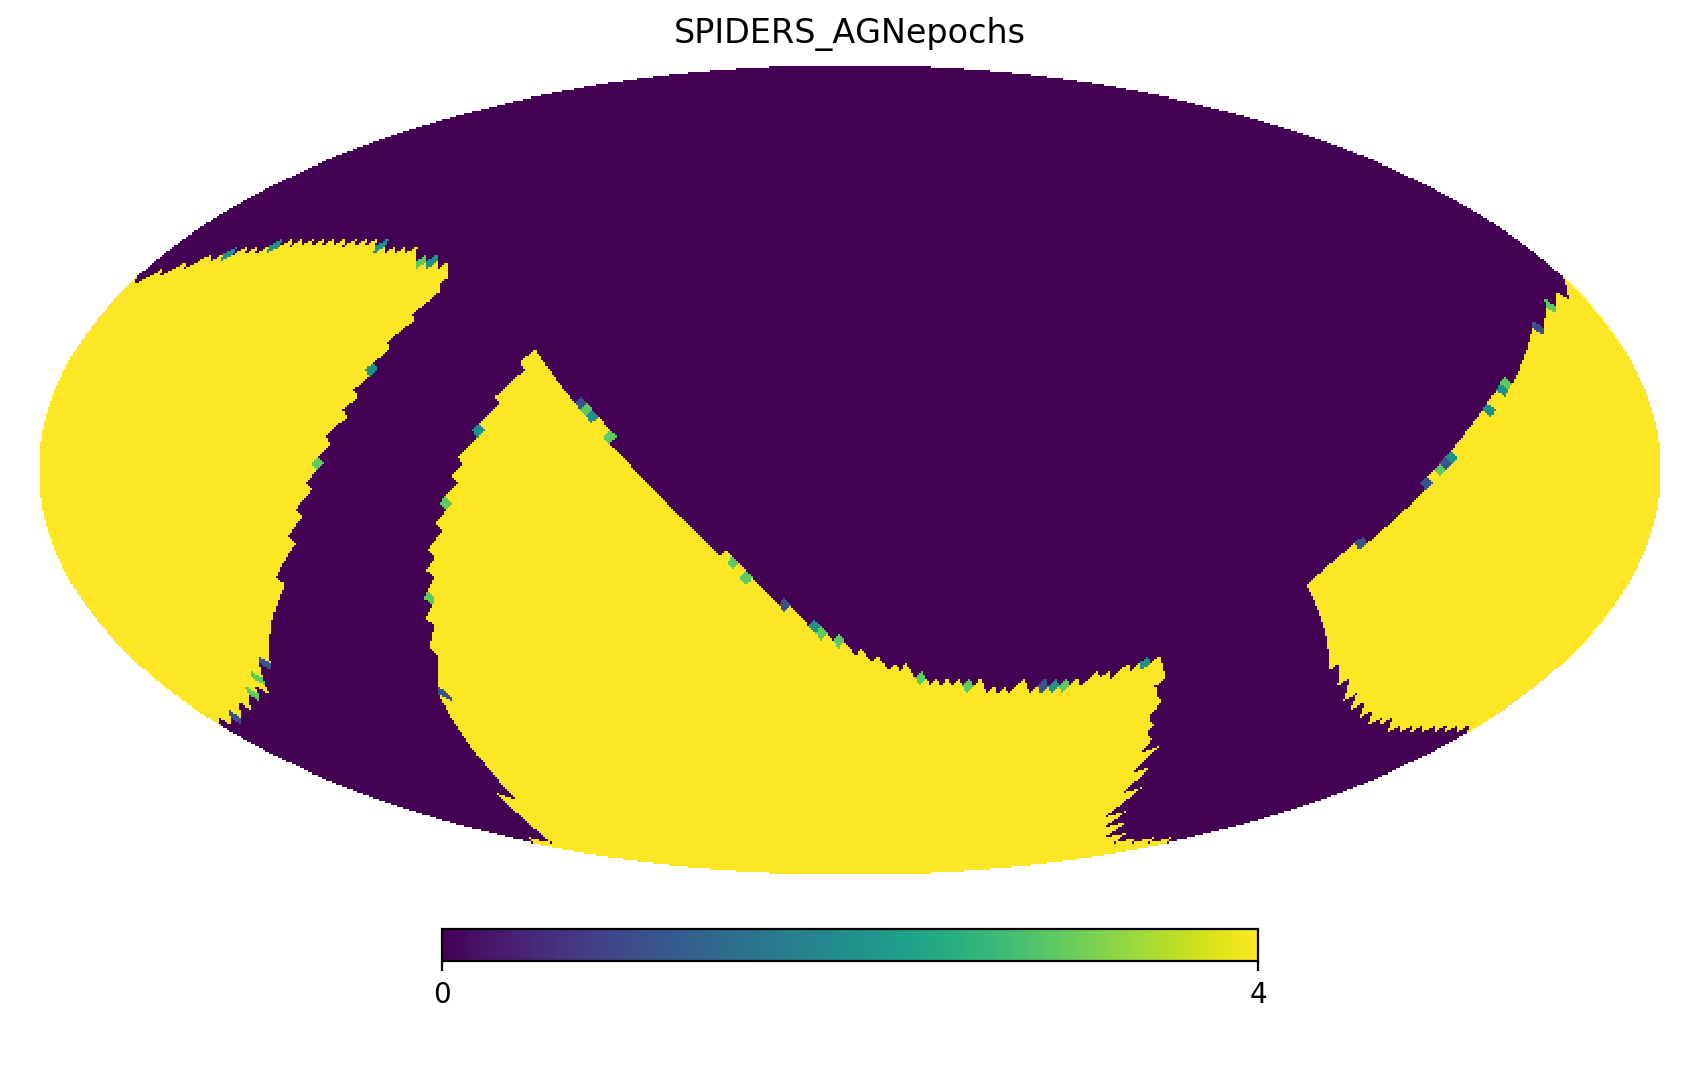

<IPython.core.display.Javascript object>


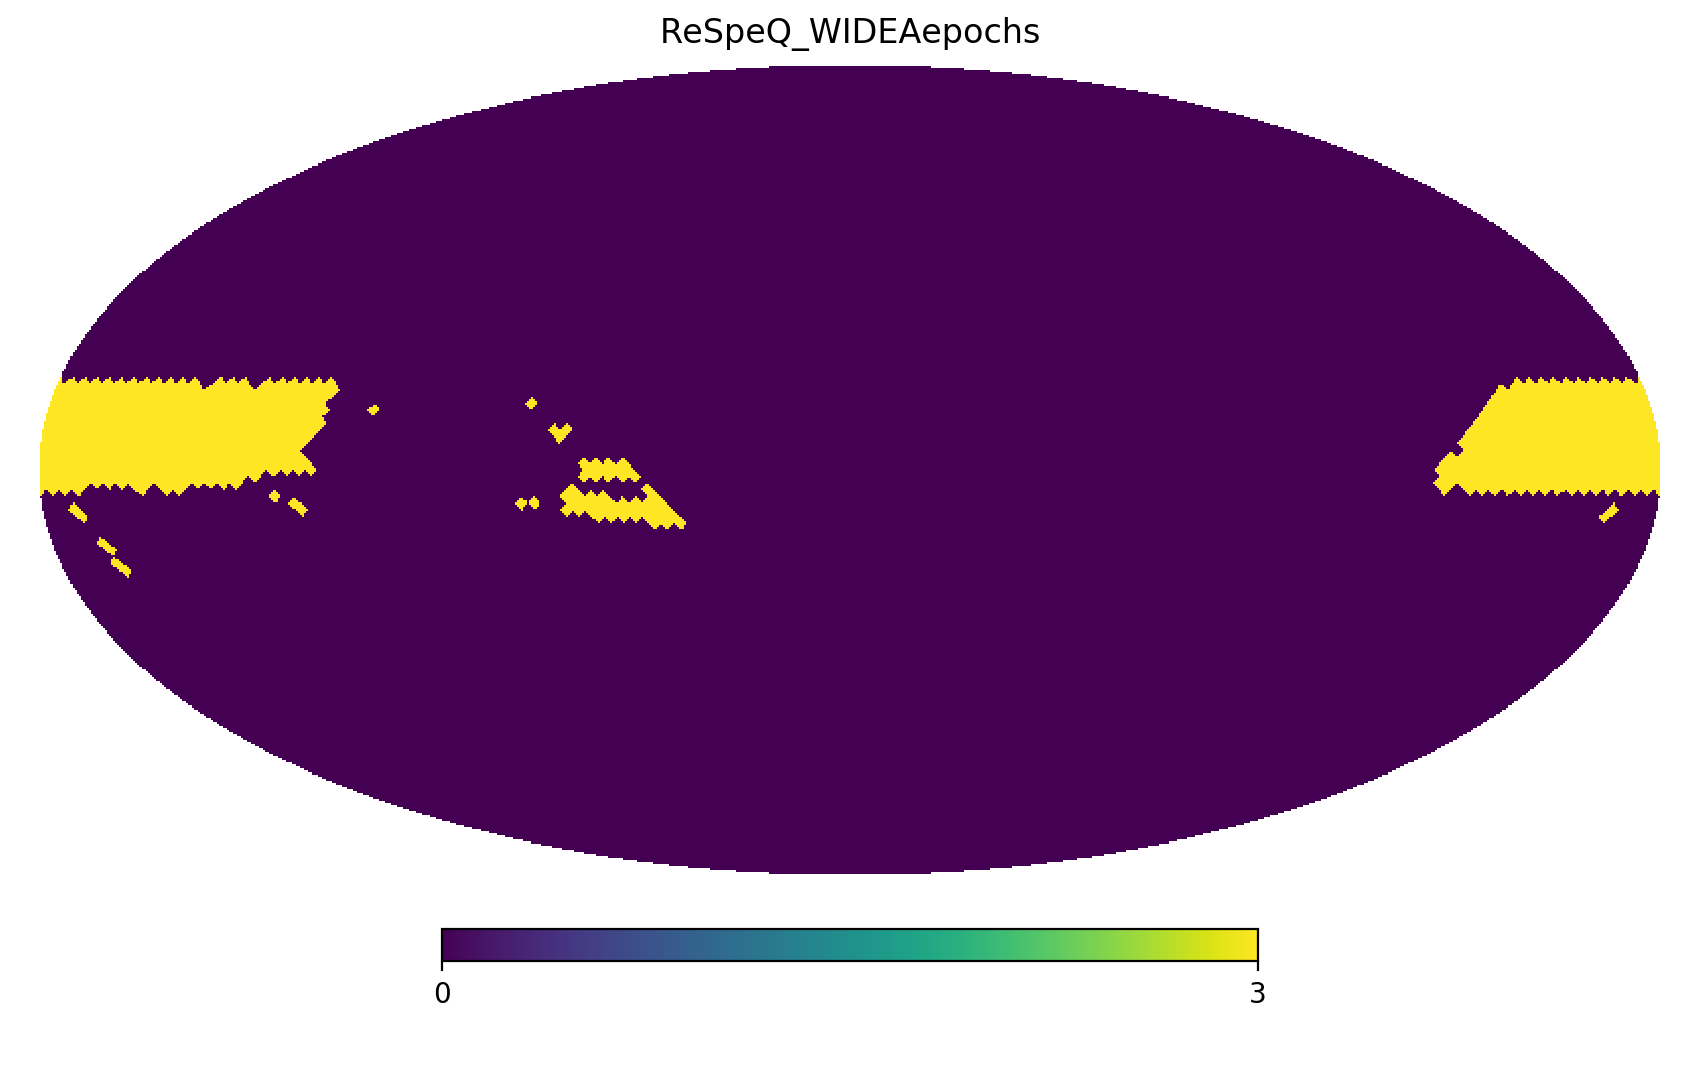

<IPython.core.display.Javascript object>


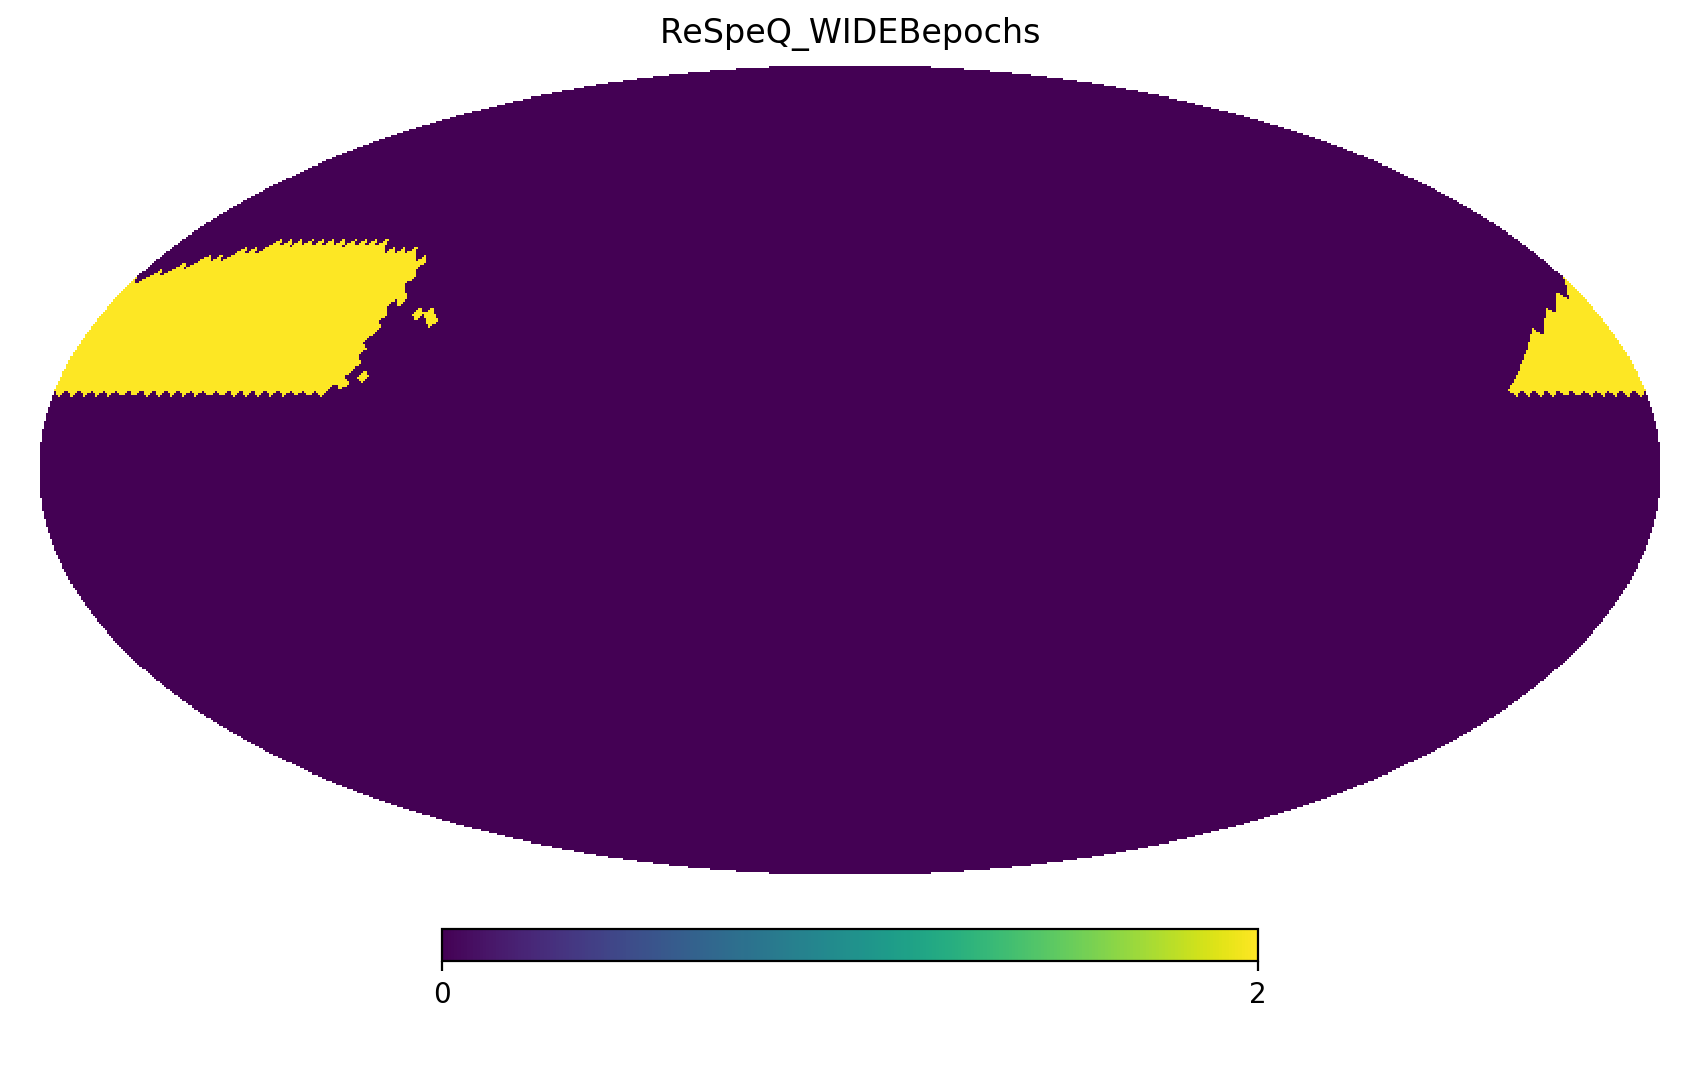

<IPython.core.display.Javascript object>


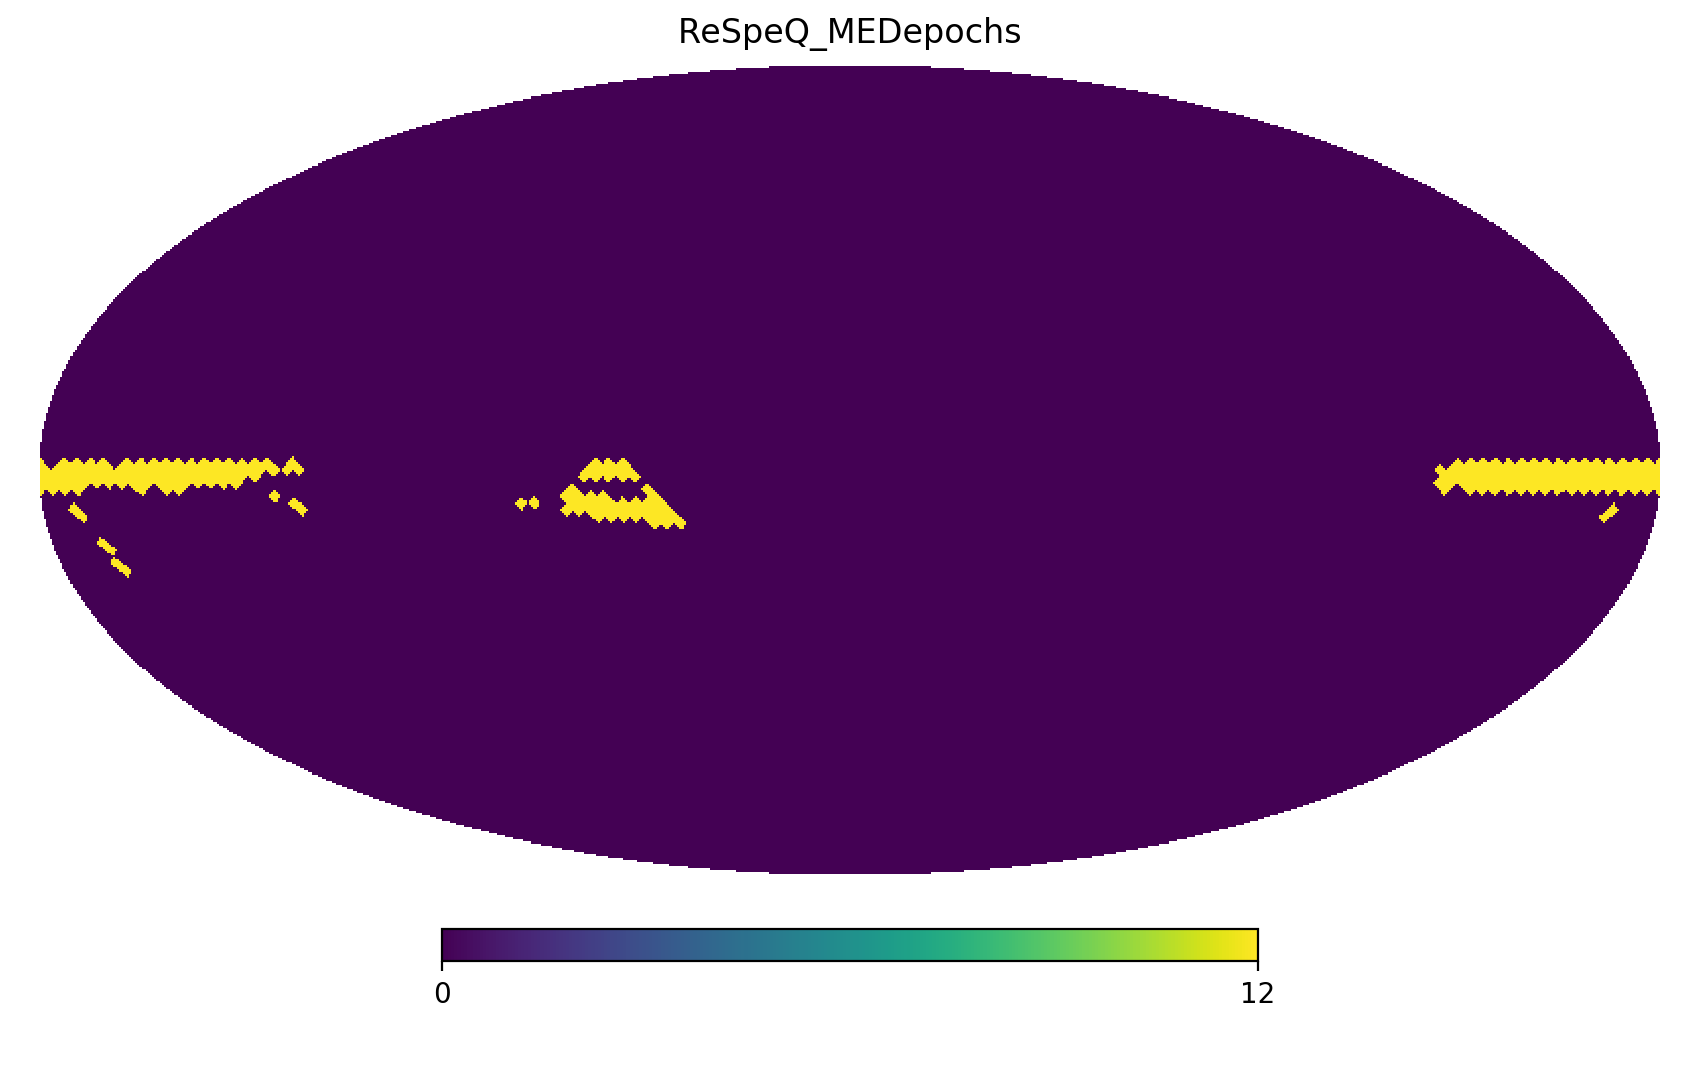

<IPython.core.display.Javascript object>


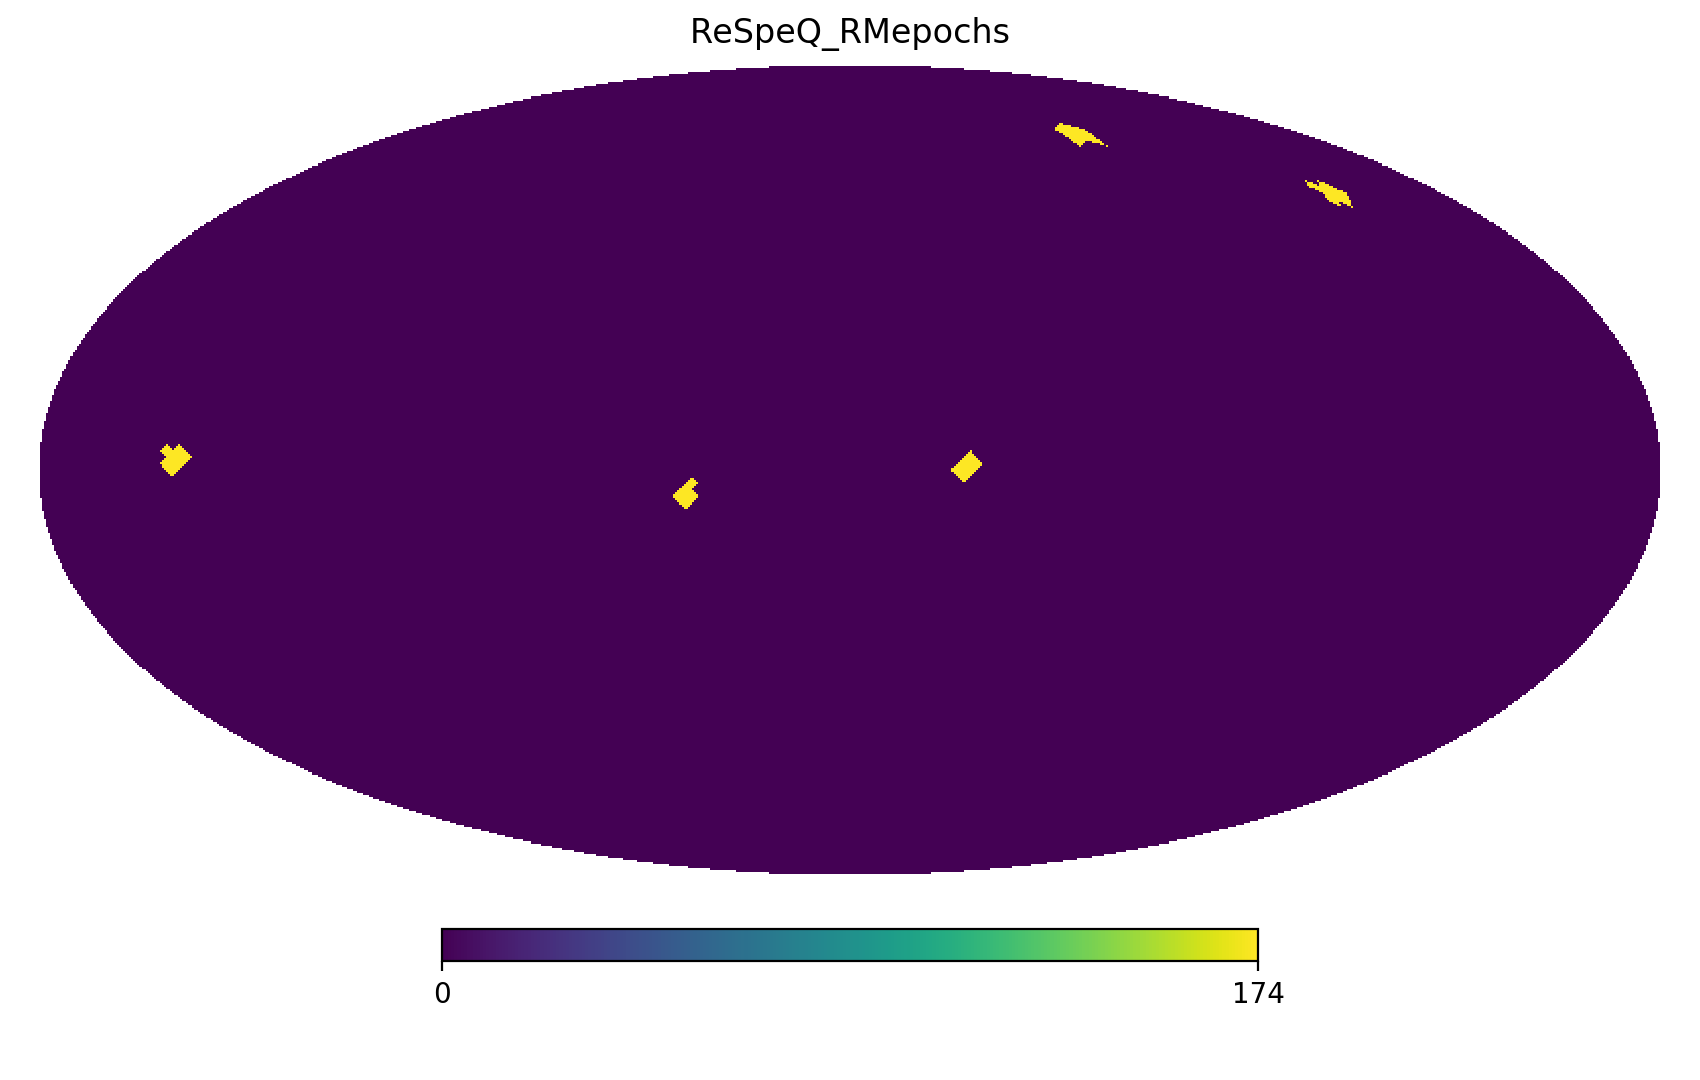

In [63]:
for indx in range(len(pindex)):
    healpy.mollview(pmap[:, indx], title=indexp[indx] + "epochs")

<IPython.core.display.Javascript object>


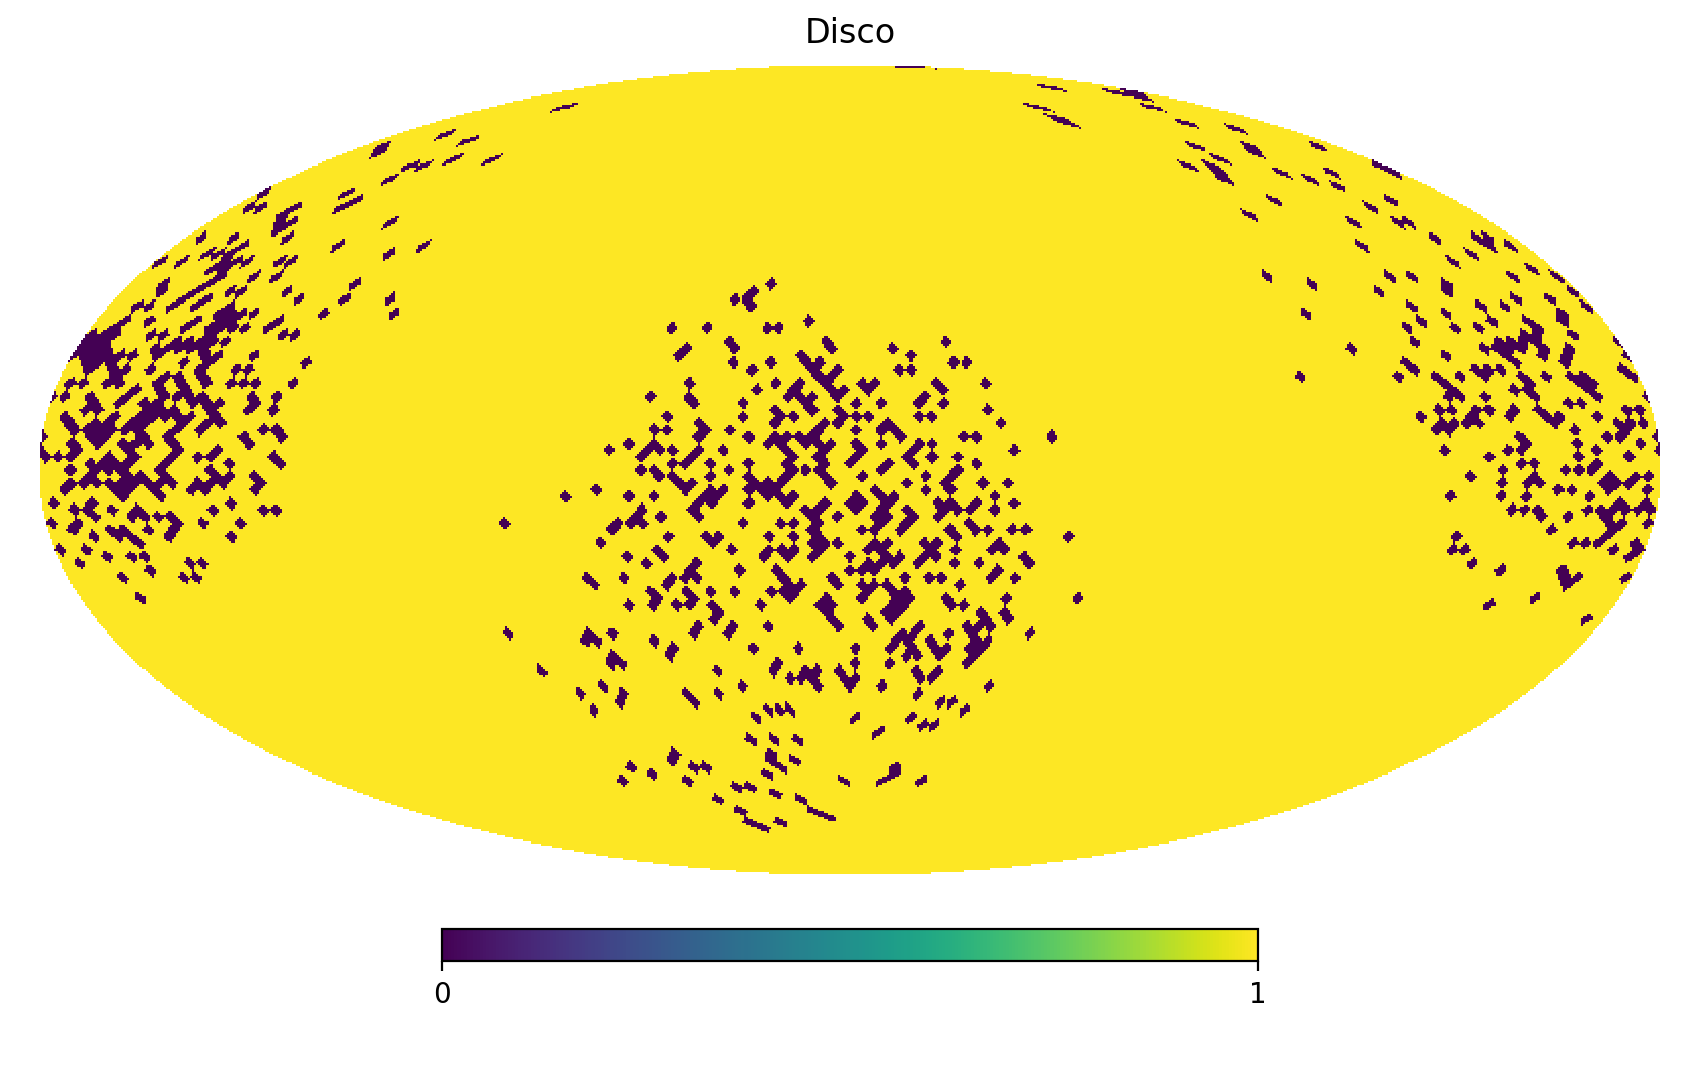

<IPython.core.display.Javascript object>


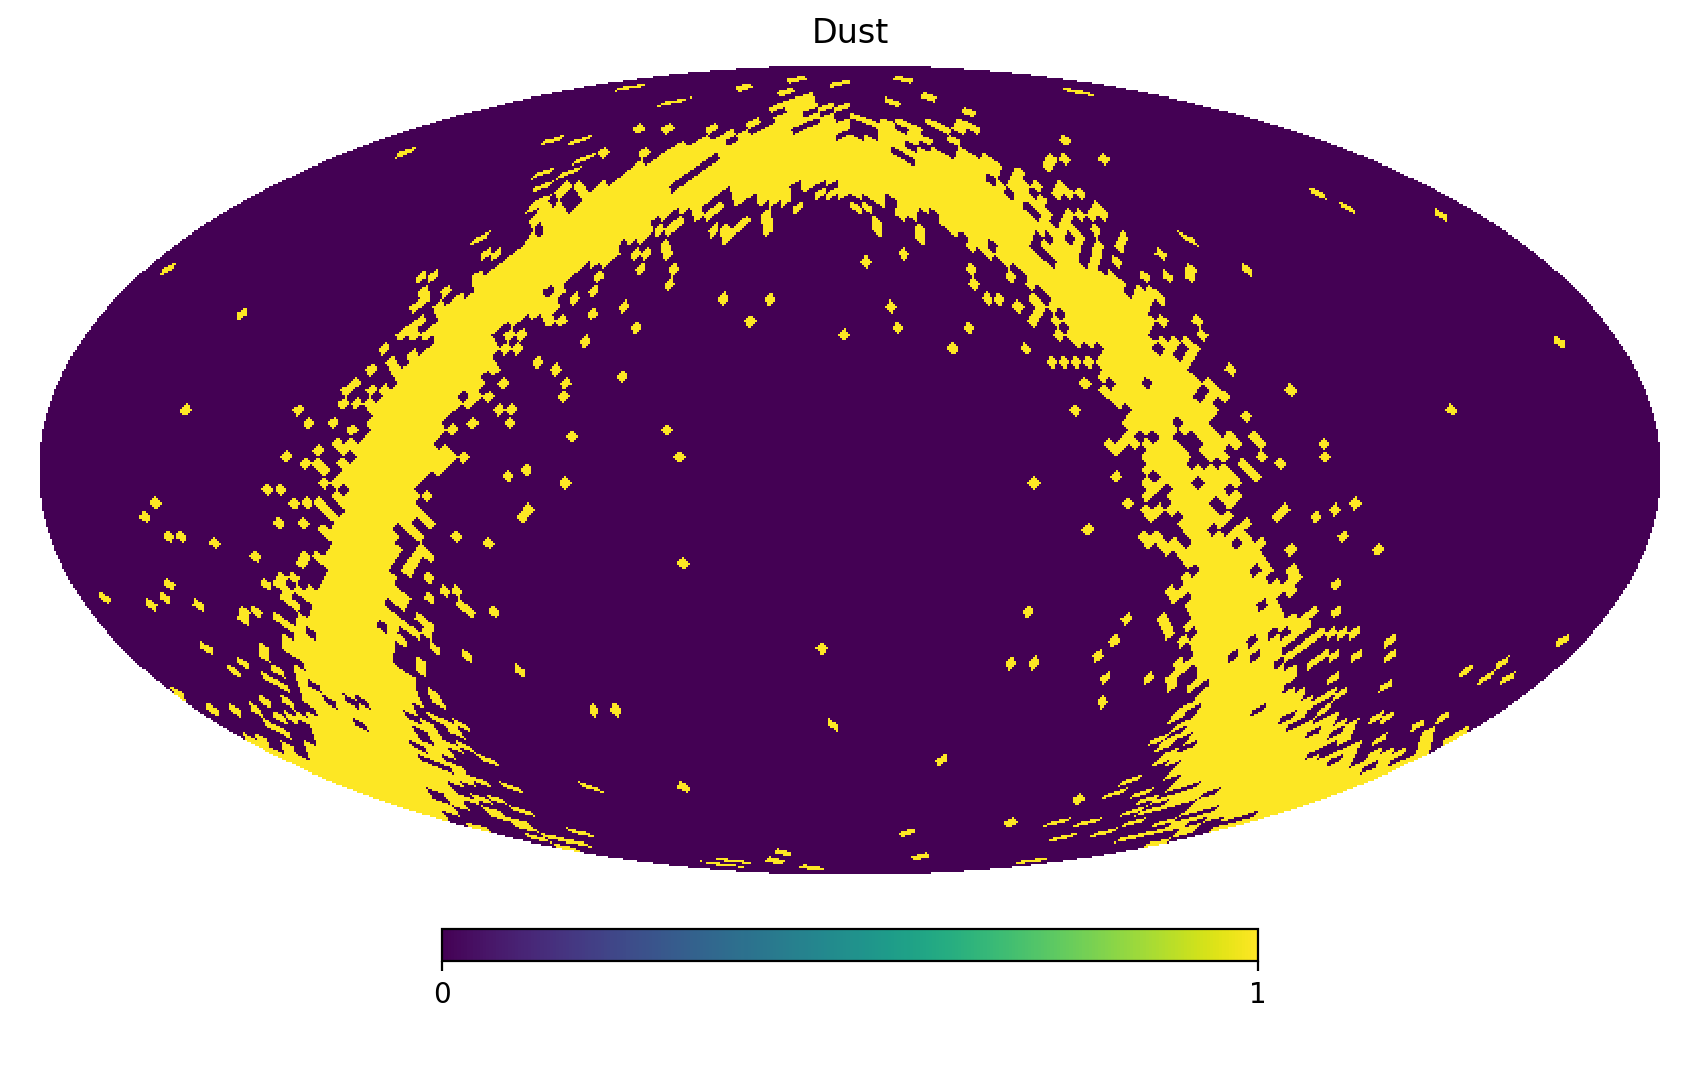

<IPython.core.display.Javascript object>


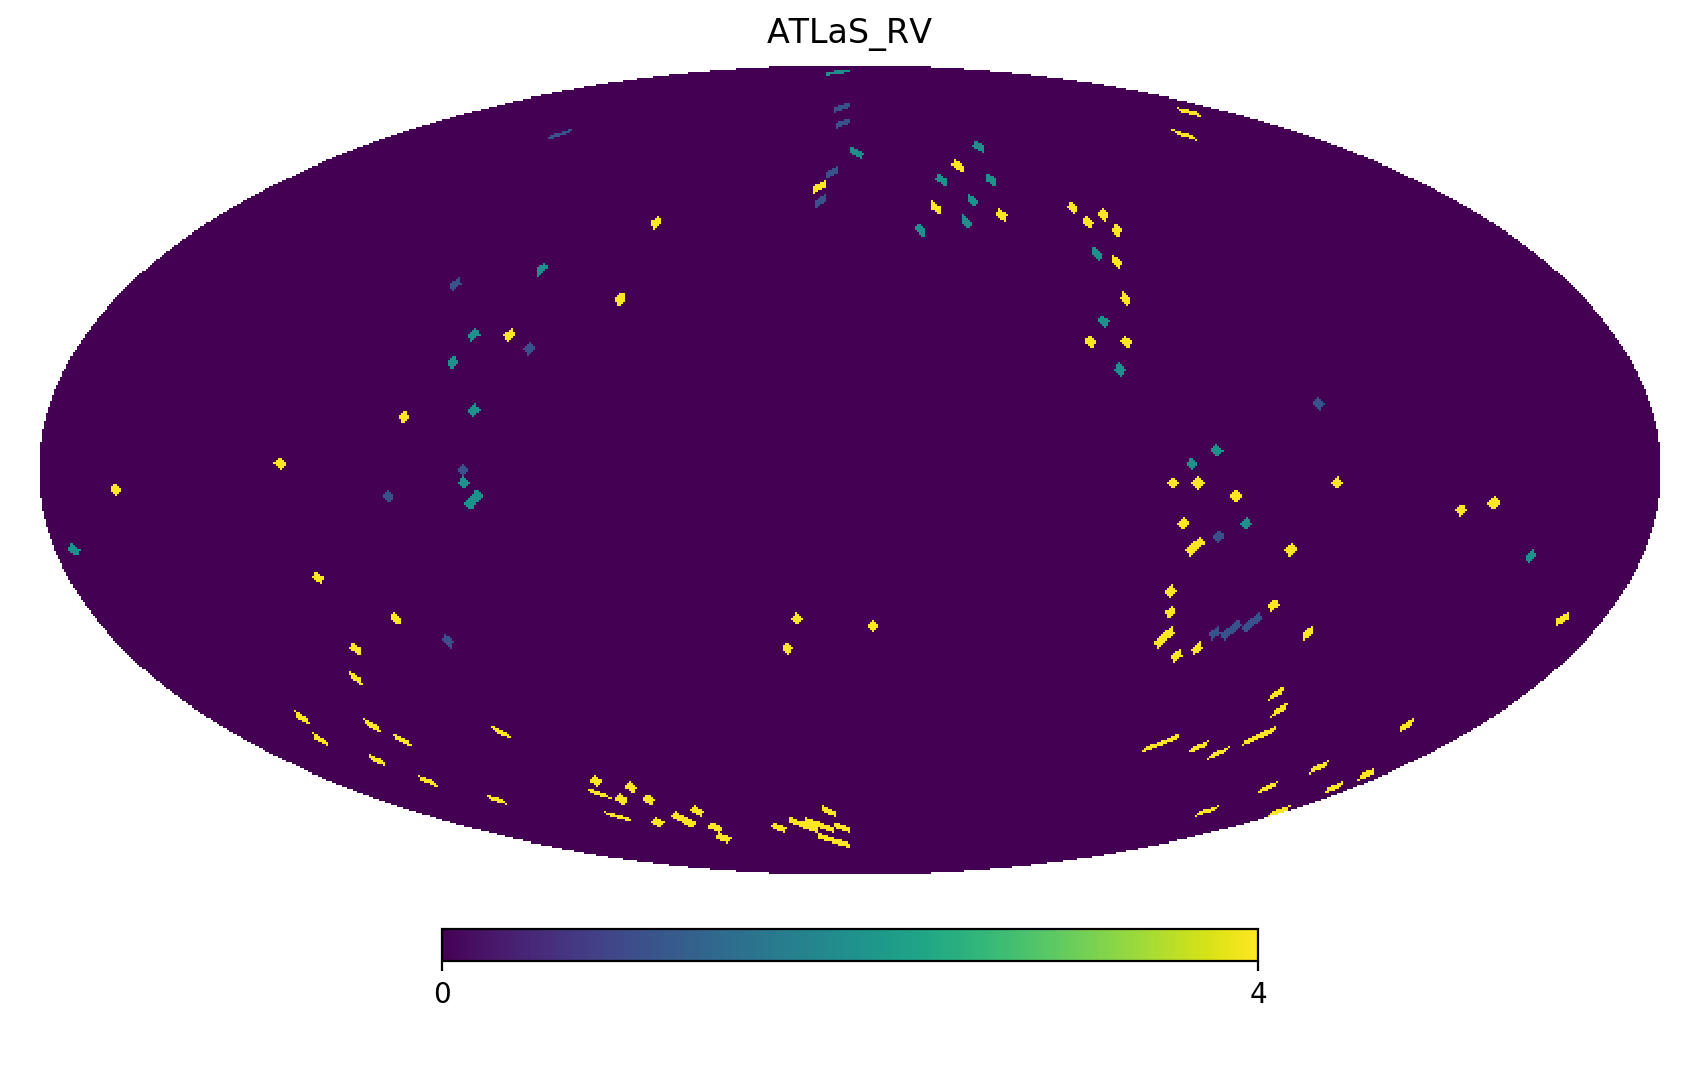

<IPython.core.display.Javascript object>


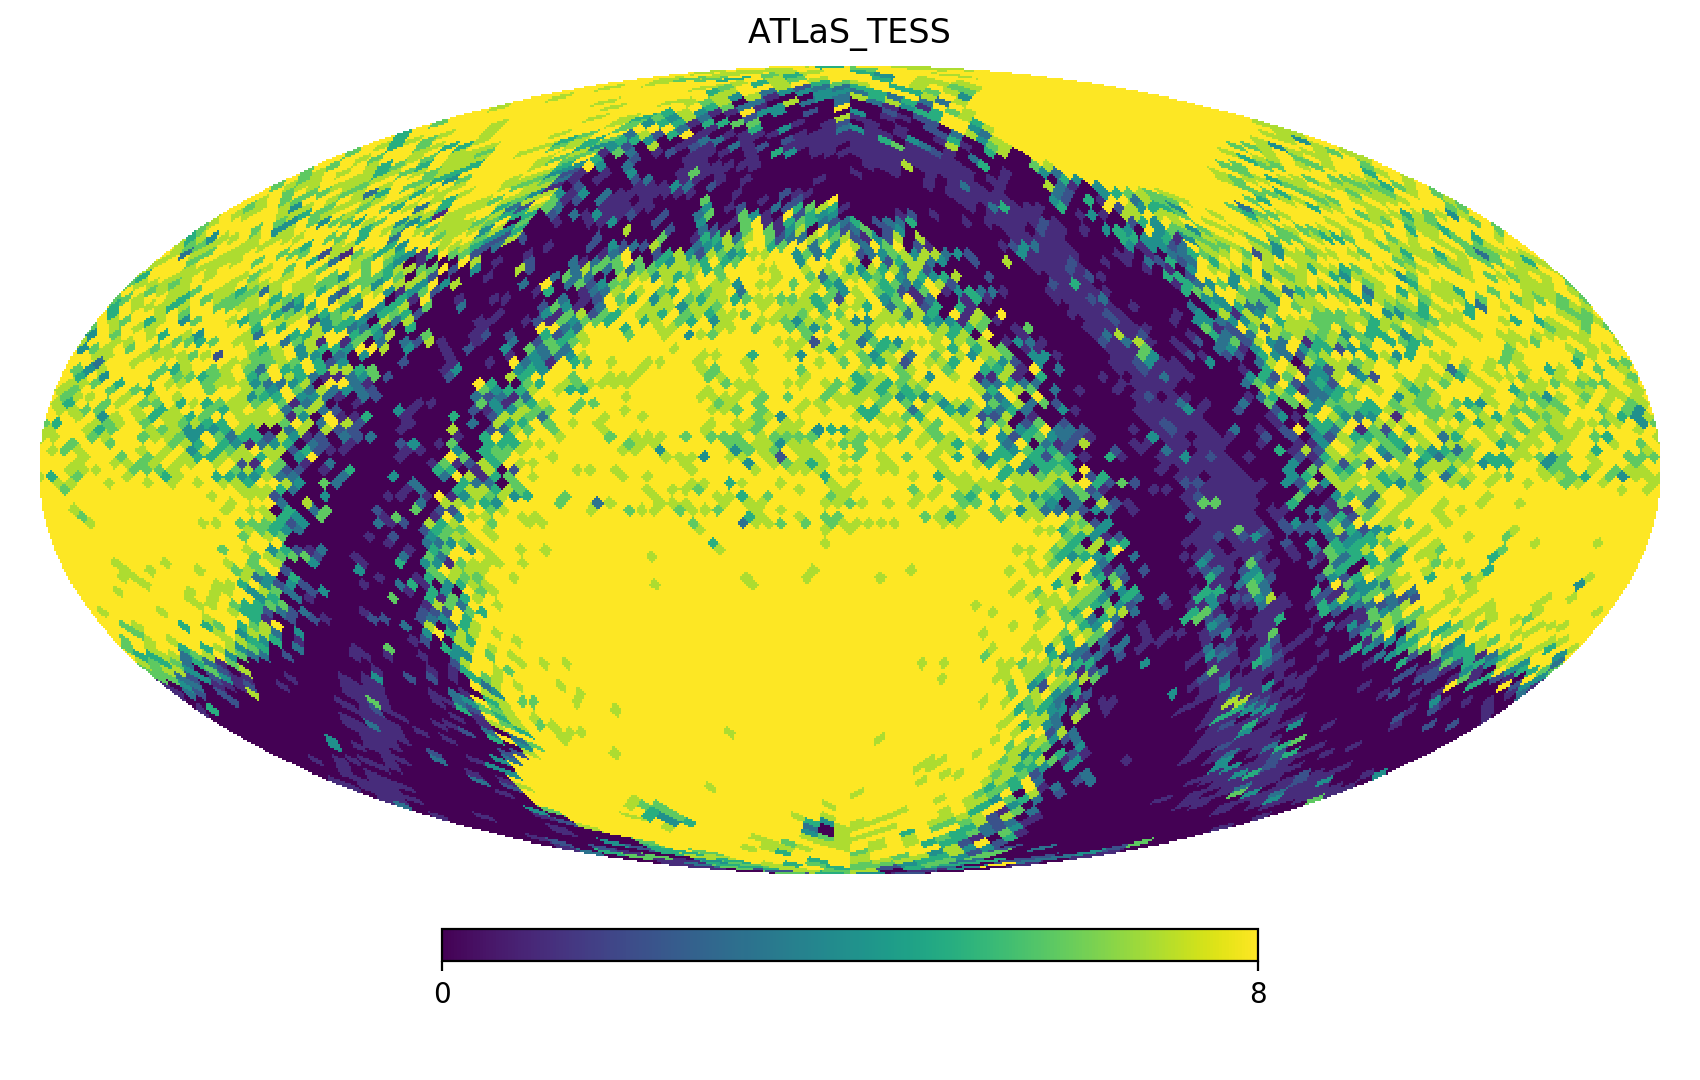

<IPython.core.display.Javascript object>


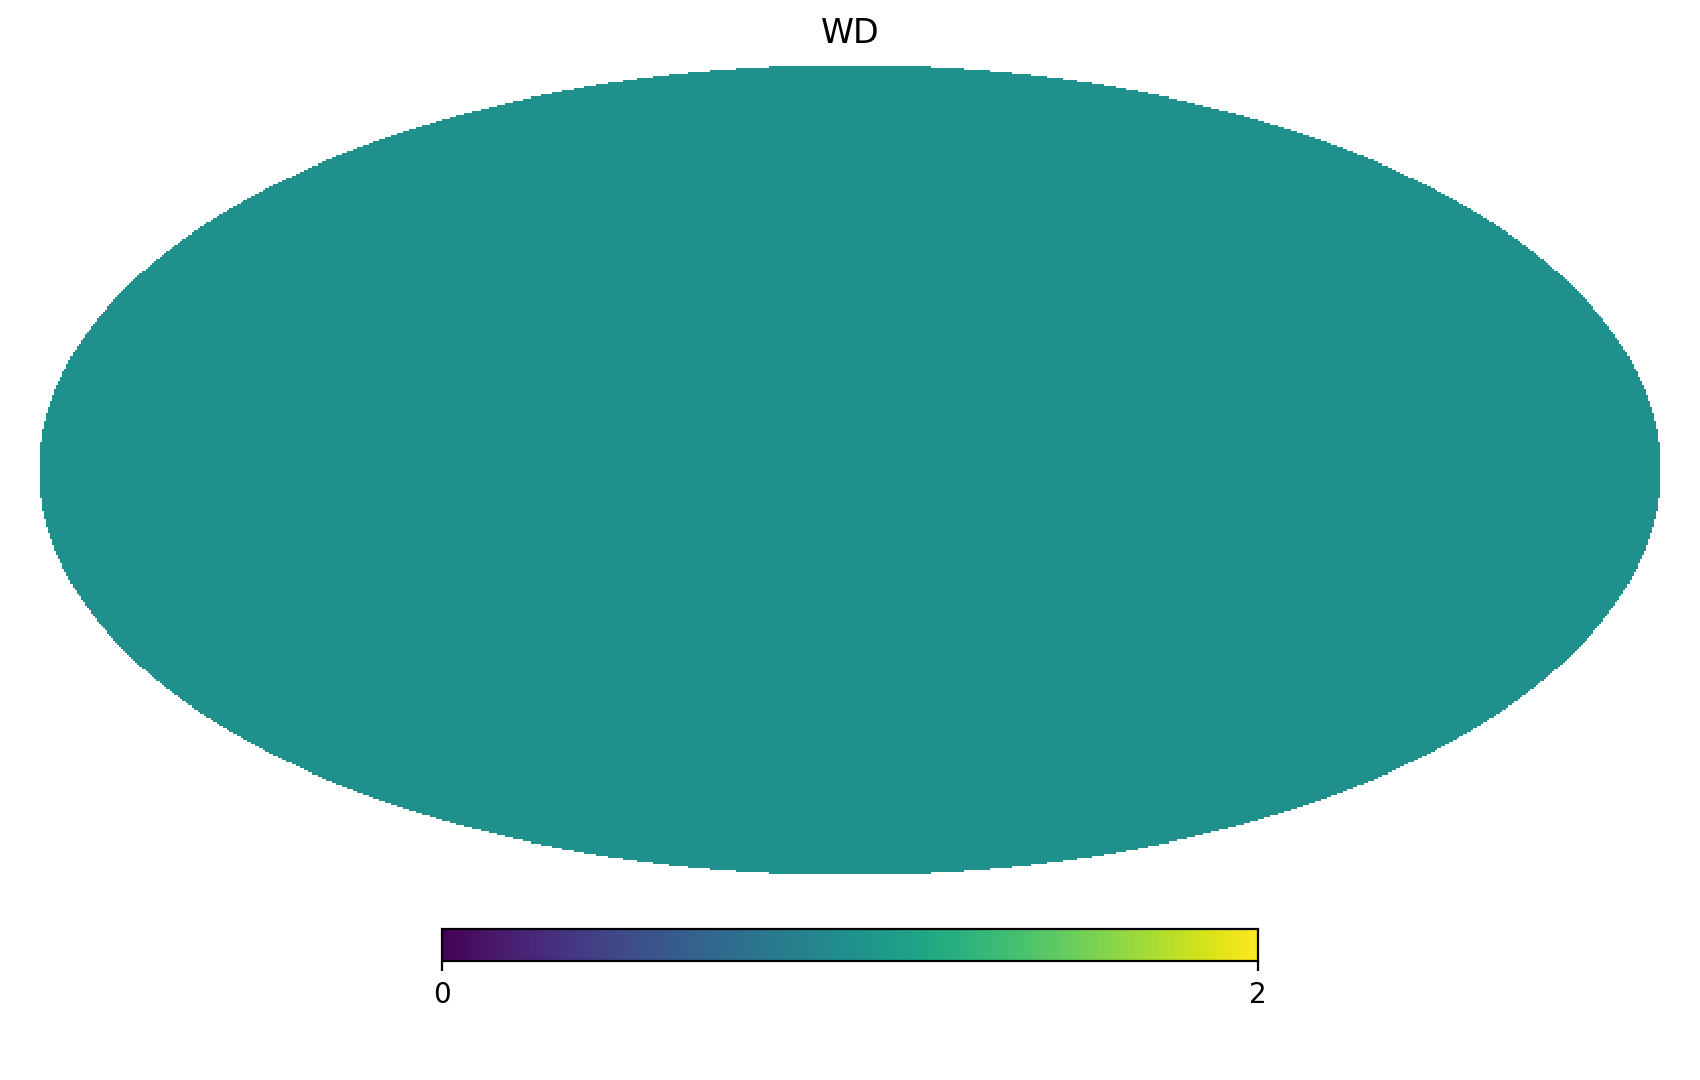

<IPython.core.display.Javascript object>


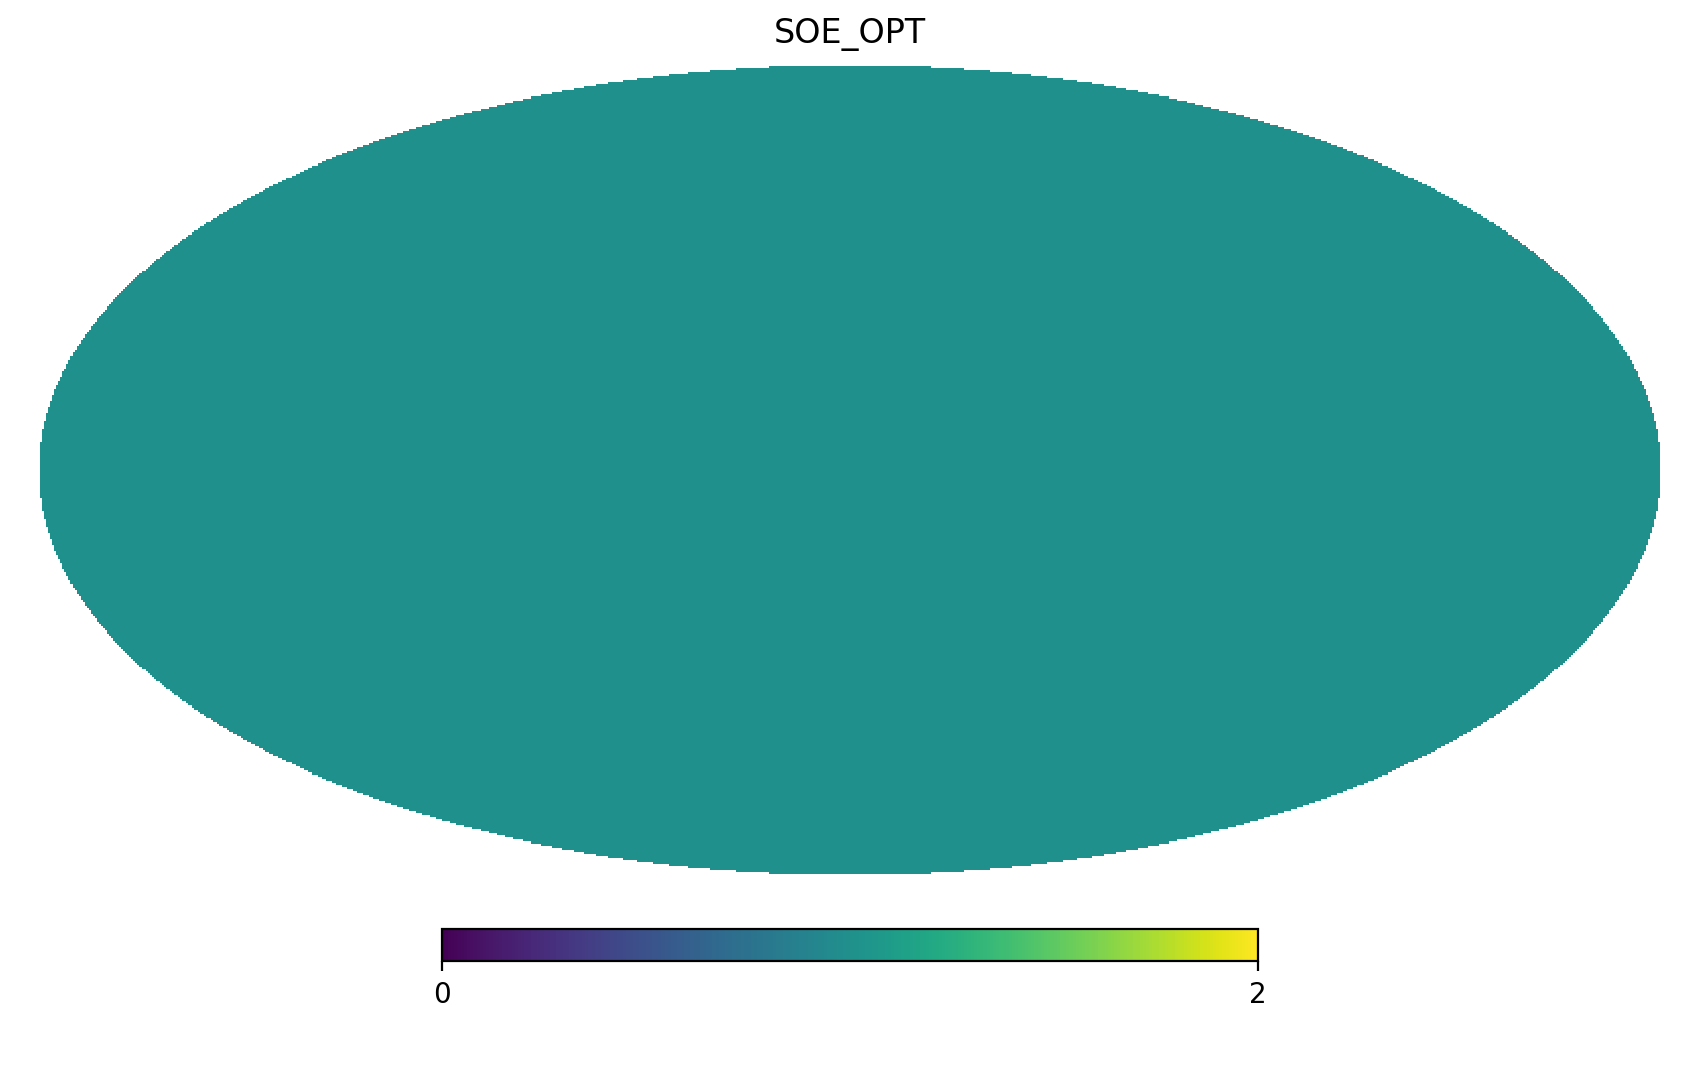

<IPython.core.display.Javascript object>


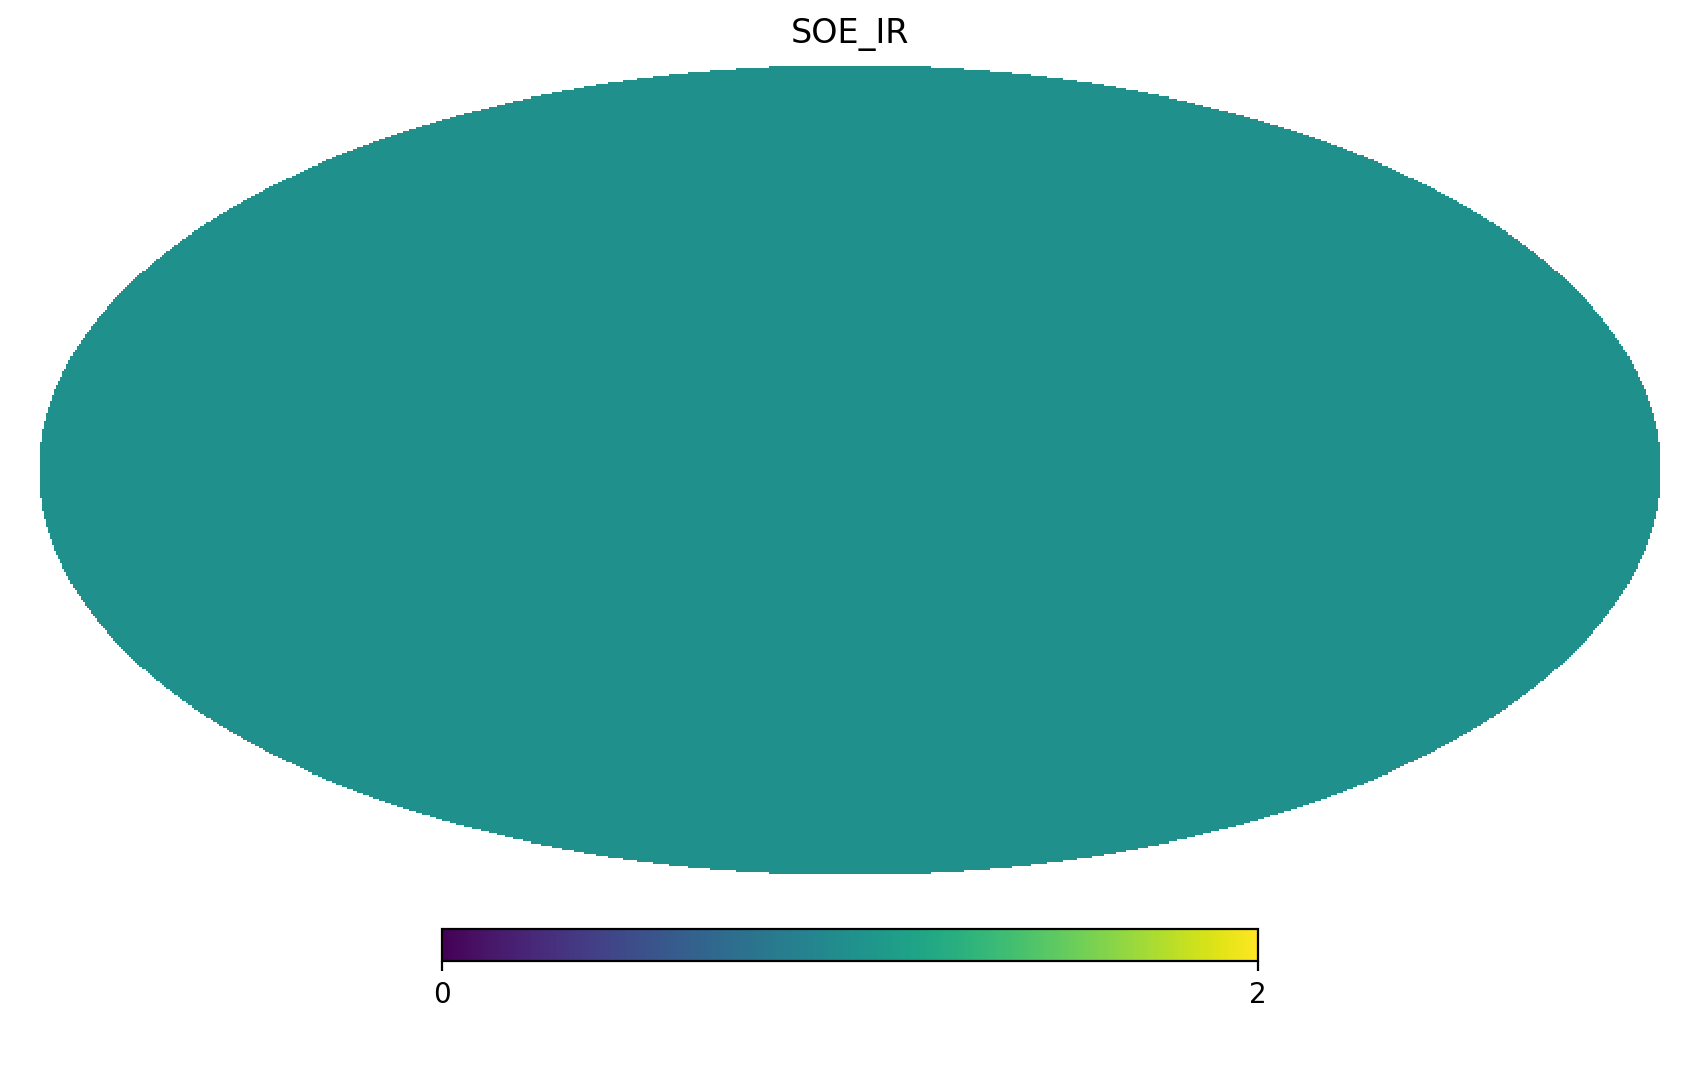

<IPython.core.display.Javascript object>


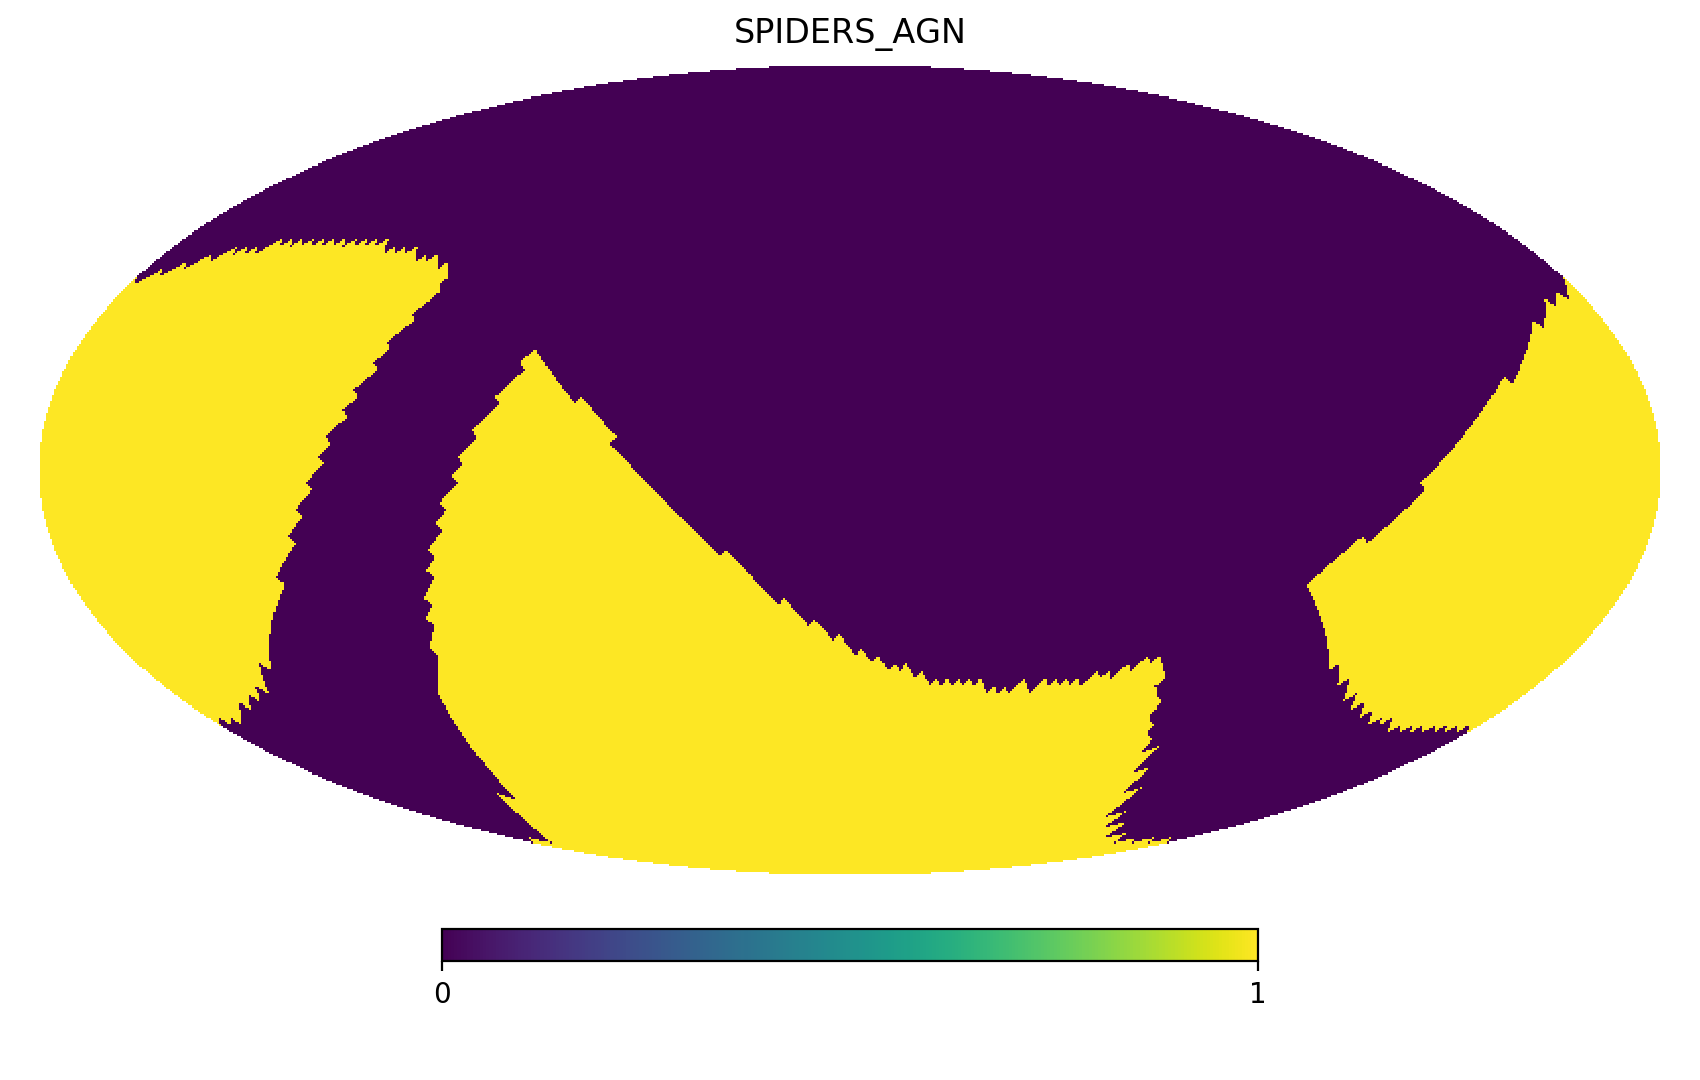

<IPython.core.display.Javascript object>


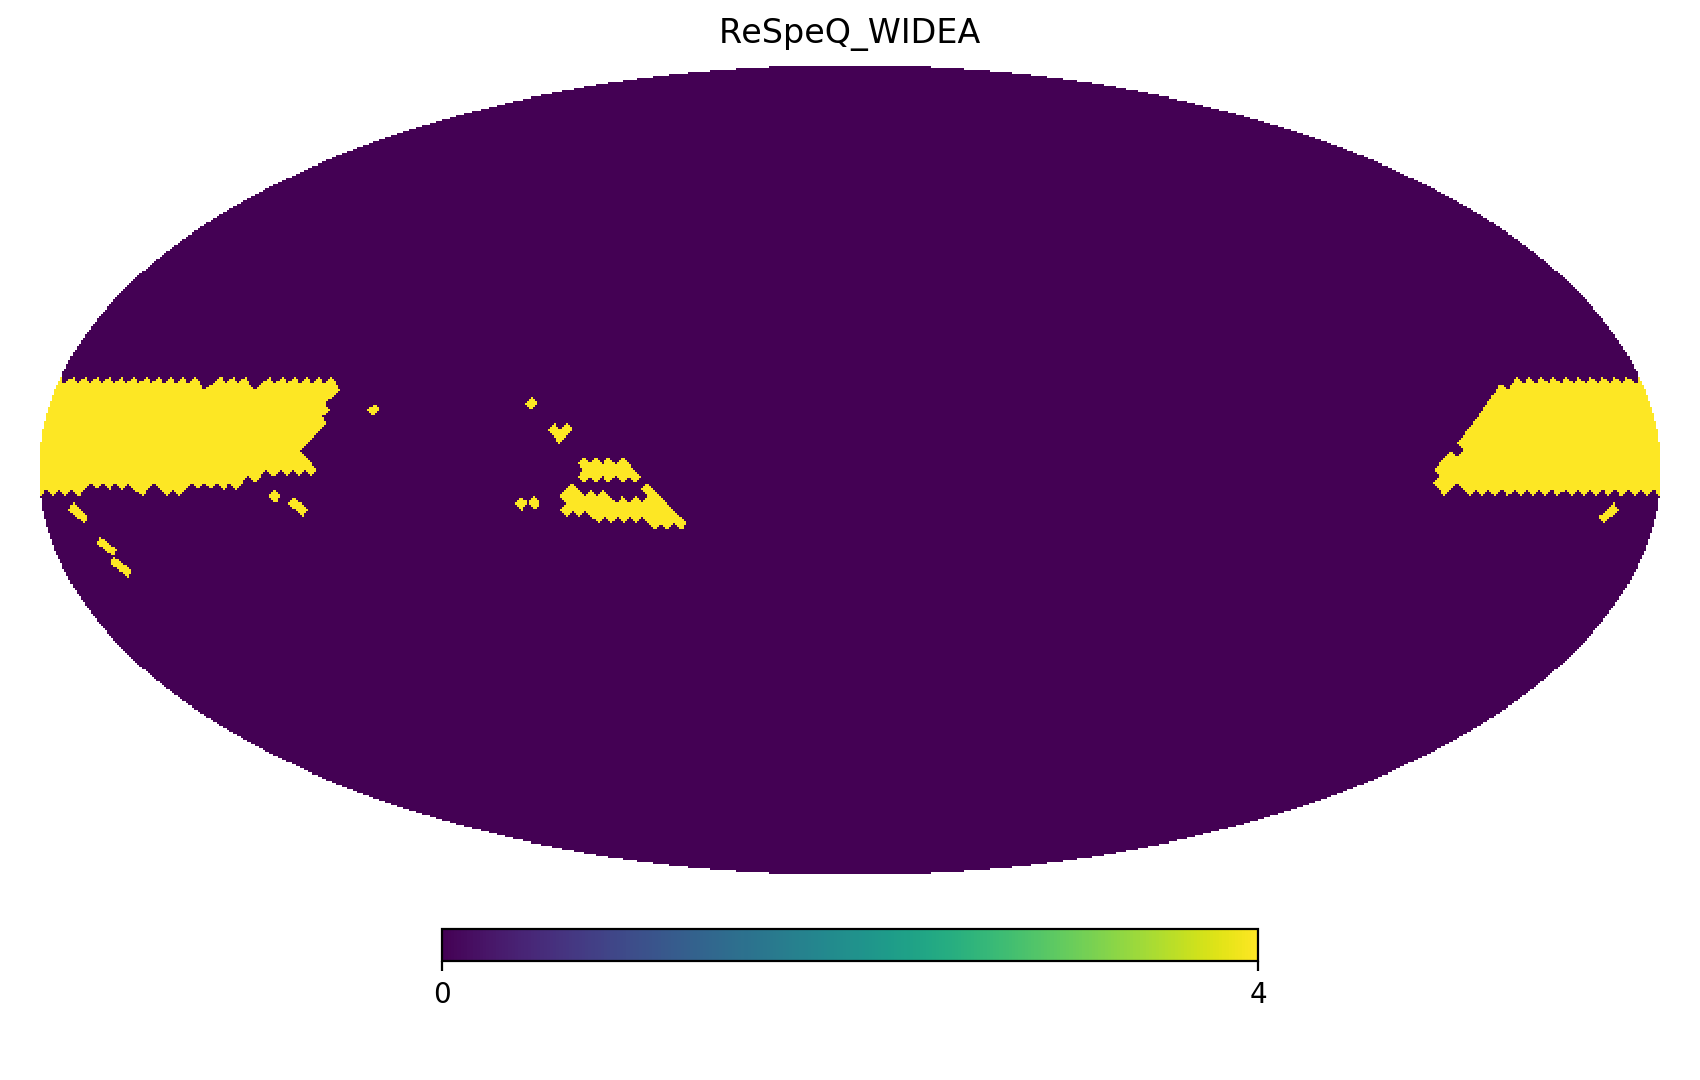

<IPython.core.display.Javascript object>


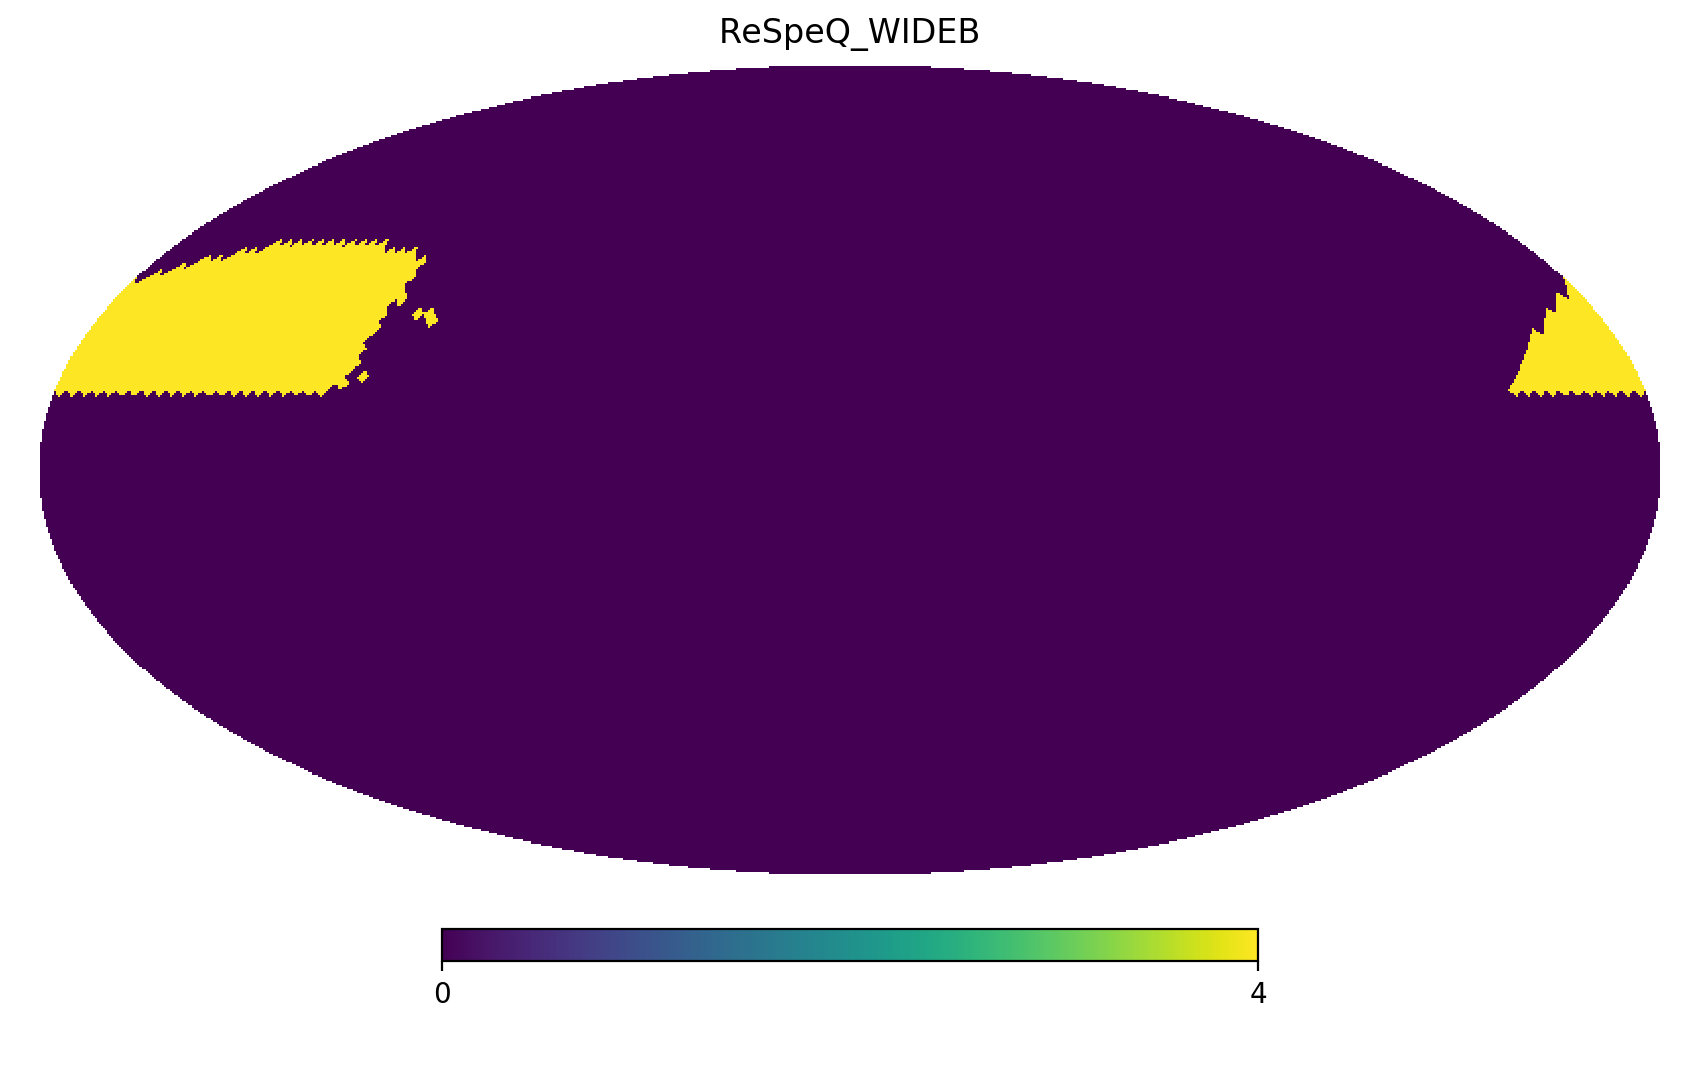

<IPython.core.display.Javascript object>


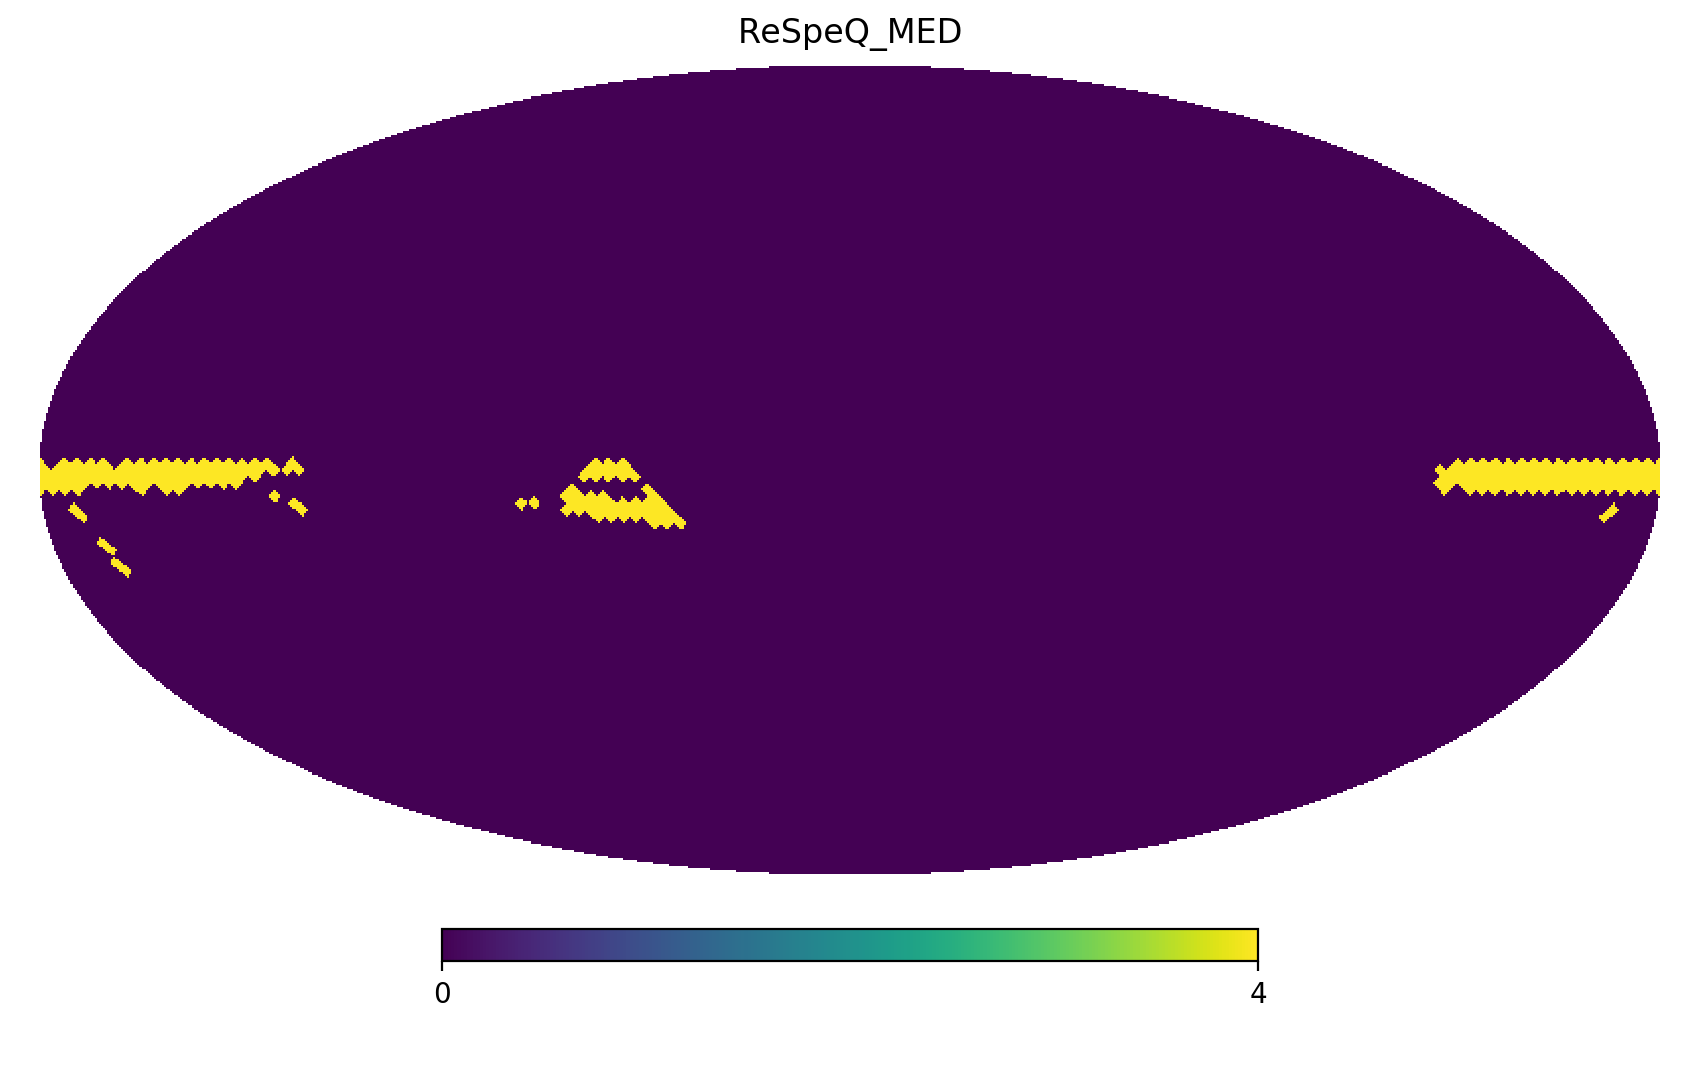

<IPython.core.display.Javascript object>


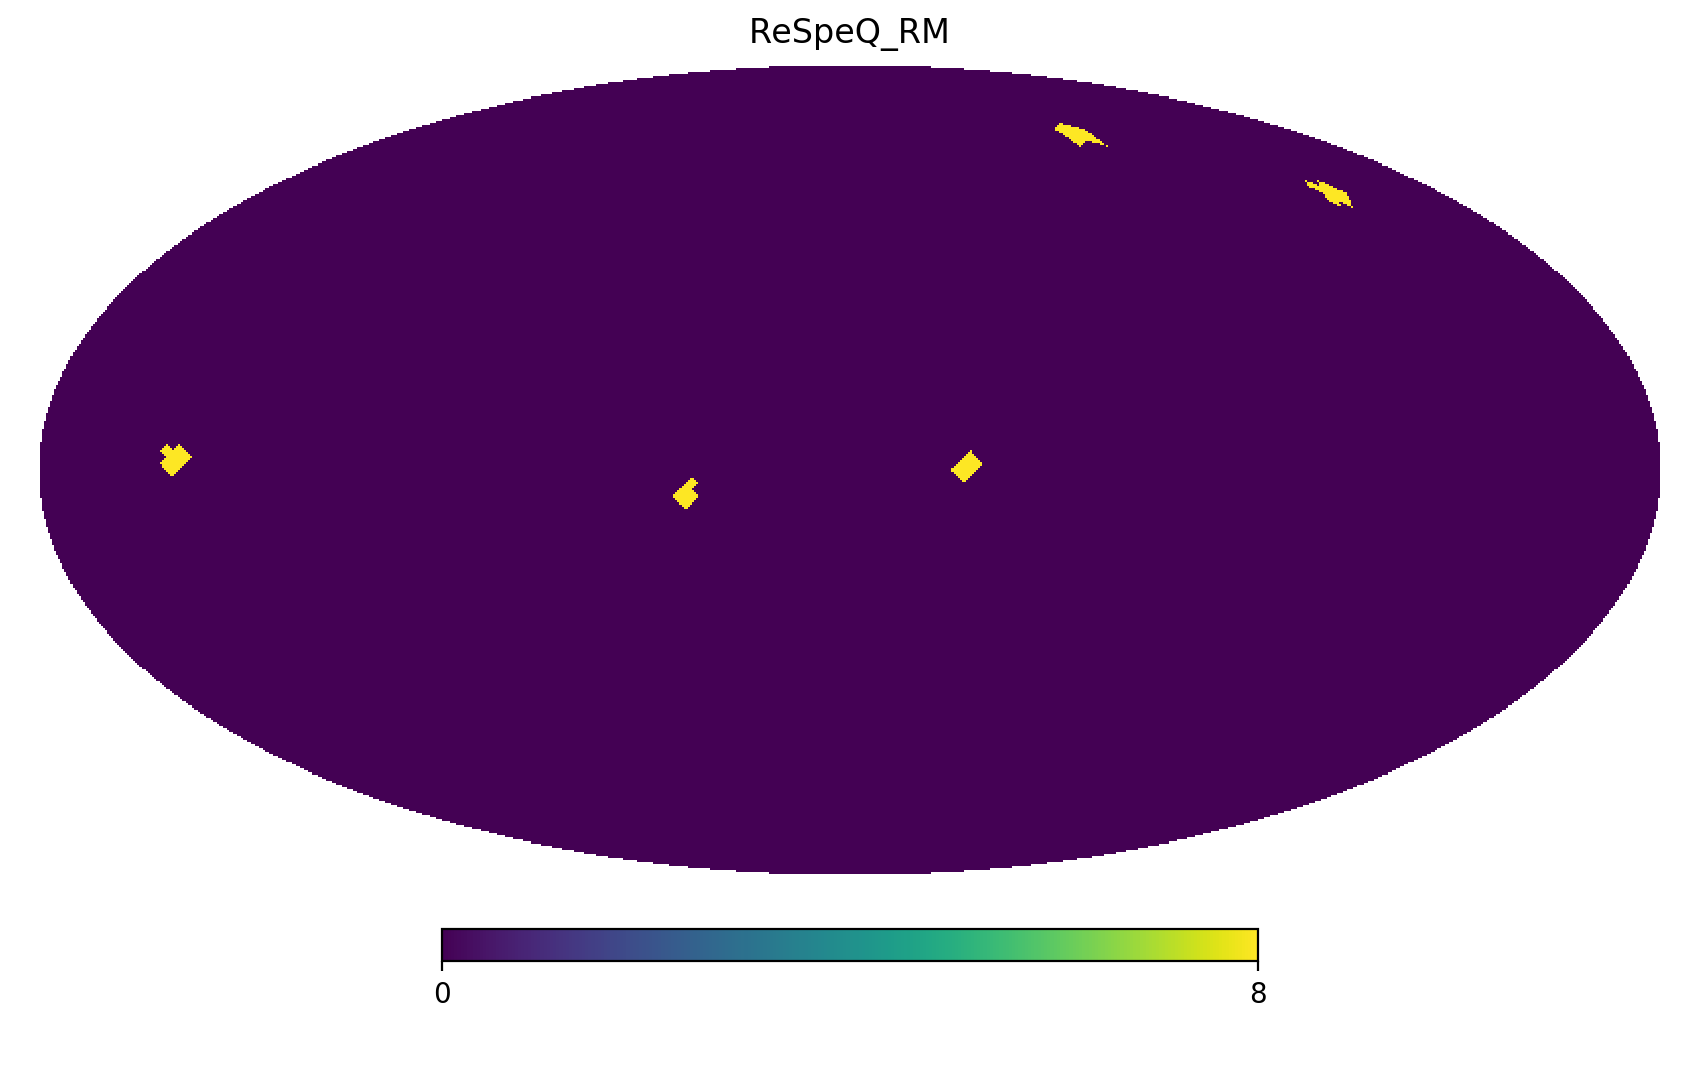

In [54]:
for indx in range(len(pindex)):
    healpy.mollview(pmap_nexp[:, indx], title=indexp[indx])

## Variety of maps in each cell

In [23]:
npmap = pmap.sum(axis=1) 

First, let's look at the number of different programs in each pixel. This will give us an inkling of the complexity involved.

<IPython.core.display.Javascript object>


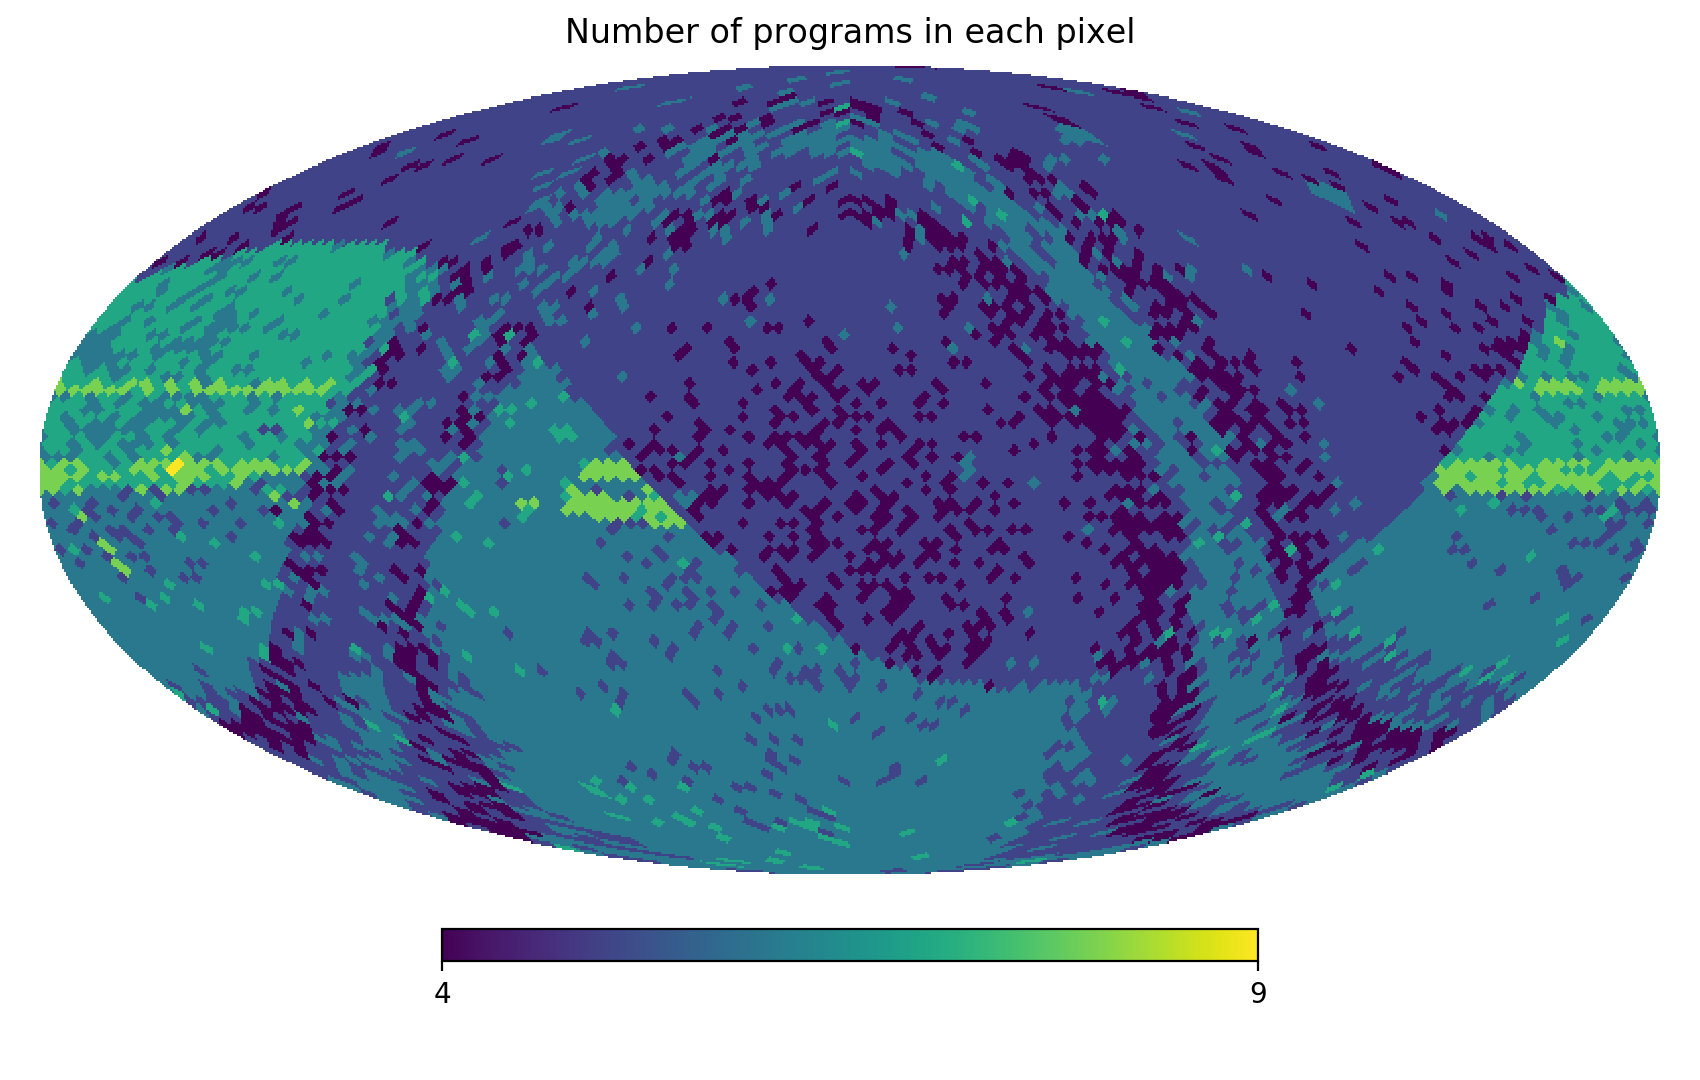

In [24]:
healpy.mollview(npmap, title='Number of programs in each pixel')

So there are four to nine programs executed at any given point on the sky. However, that understates the complexity of the situation. Below we determine the "types" of pixels --- i.e. how many combinations there are of each program. There are fifty-one such combinations! This is complex.

In [55]:
bits = np.outer(np.ones(healpy.nside2npix(nside), dtype=np.int32),
                2**np.arange(len(pindex), dtype=np.int32))
ptypes = (np.int32(pmap > 0) * bits).sum(axis=1)

In [56]:
def mask2names(bits):
    names = ""
    for indx in np.arange(len(pindex)):
        if((bits & 2**indx) != 0):
            names = names + indexp[indx] + " "
    return(names)

In [57]:
print(len(np.unique(ptypes)))
for ptype in np.unique(ptypes):
    print(mask2names(ptype))

51
Disco WD SOE_OPT SOE_IR 
Disco Dust WD SOE_OPT SOE_IR 
Disco ATLaS_RV WD SOE_OPT SOE_IR 
Disco Dust ATLaS_RV WD SOE_OPT SOE_IR 
ATLaS_TESS WD SOE_OPT SOE_IR 
Disco ATLaS_TESS WD SOE_OPT SOE_IR 
Dust ATLaS_TESS WD SOE_OPT SOE_IR 
Disco Dust ATLaS_TESS WD SOE_OPT SOE_IR 
ATLaS_RV ATLaS_TESS WD SOE_OPT SOE_IR 
Disco ATLaS_RV ATLaS_TESS WD SOE_OPT SOE_IR 
Disco Dust ATLaS_RV ATLaS_TESS WD SOE_OPT SOE_IR 
WD SOE_OPT SOE_IR SPIDERS_AGN 
Disco WD SOE_OPT SOE_IR SPIDERS_AGN 
Disco Dust WD SOE_OPT SOE_IR SPIDERS_AGN 
Disco ATLaS_RV WD SOE_OPT SOE_IR SPIDERS_AGN 
ATLaS_TESS WD SOE_OPT SOE_IR SPIDERS_AGN 
Disco ATLaS_TESS WD SOE_OPT SOE_IR SPIDERS_AGN 
Dust ATLaS_TESS WD SOE_OPT SOE_IR SPIDERS_AGN 
Disco Dust ATLaS_TESS WD SOE_OPT SOE_IR SPIDERS_AGN 
ATLaS_RV ATLaS_TESS WD SOE_OPT SOE_IR SPIDERS_AGN 
Disco ATLaS_RV ATLaS_TESS WD SOE_OPT SOE_IR SPIDERS_AGN 
Disco Dust WD SOE_OPT SOE_IR ReSpeQ_WIDEA 
WD SOE_OPT SOE_IR SPIDERS_AGN ReSpeQ_WIDEA 
Disco WD SOE_OPT SOE_IR SPIDERS_AGN ReSpeQ_WIDEA 
Di

However, this picture leaves out both the fact that multiple programs sometimes have the same cadence rules, and within the same program there are multiple cadence rules. We don't have any expression by the teams of their cadence rules except n_epochs and n_exp_per_epoch. So we'll check that.

In [37]:
cadence = tcat['n_epochs'] * np.int32(10) + tcat['n_exp_per_epoch']
ucadences = np.unique(cadence)
ncadence = len(ucadences)
cadence2indx = dict()
for indx, uc in zip(np.arange(ncadence), ucadences):
    cadence2indx[uc] = indx

In [38]:
cbits = np.zeros(healpy.nside2npix(nside), dtype=np.int32)
for h, ne, npe in zip(tcat['hpix'], tcat['n_epochs'], tcat['n_exp_per_epoch']):
    cc = ne * 10 + npe
    indx = cadence2indx[cc]
    cbits[h] = cbits[h] + 2**indx

In [39]:
print(len(np.unique(cbits)))

11427


Uh, let us take a look at that.

<IPython.core.display.Javascript object>


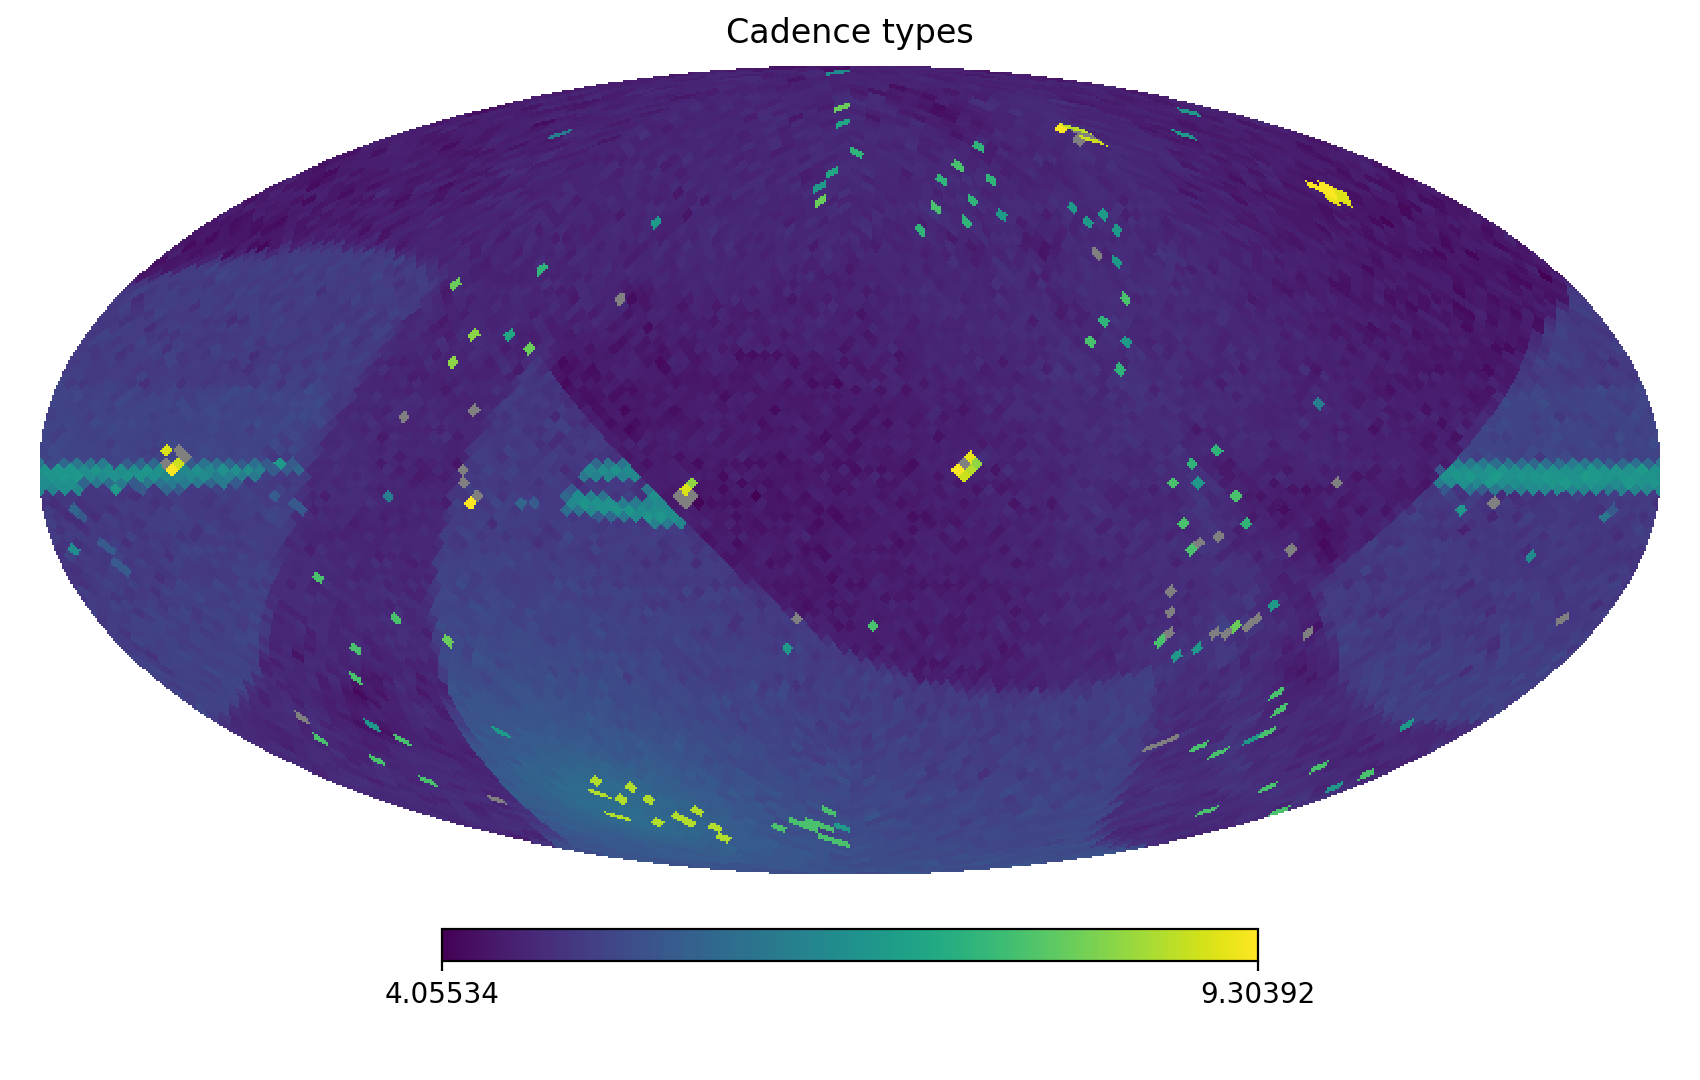

In [40]:
healpy.mollview(np.log10(cbits), title='Cadence types')

So, if we take the inputs seriously, most tiles on the sky has its own unique sort of cadence requirements based on the objects that are there. The cadence rules tend to be a little complicated in reality, so we require rules to figure out for each region what its cadence will be based on what combination of the 29 different cadences are present in the field. This is too complicated for 11,000 different such combinations. As I describe below, this means we need to simplify.

## Overall requirements for number of fields and tiles.

Rather than try to address the above question quite yet, we will first evaluate the overall requirements for the number of tiles necessary per field in each location. This will inform the overall resource allocation determination.

Each healpix pixel needs a number of exposures as determined as follows:

 * Each cadence category i has nepoch_i and nper_i and a number density n_i. 
 * The tiles in a given region each cover an area a_tile. 
 * The type of fiber (opt/apo) has a number per tile n_opt or n_apo

The exposure resource needs of the cadence category i if optical are therefore:

    e_i = nepoch_i * nper_i * n_i / (n_opt / a_tile)
 
The exposure resource needs of the cadence category i if apogee are:

    e_i = nepoch_i * nper_i * n_i / (n_apo / a_tile)

The exposure requirement for each pixel then is:

    max( max(nepoch_i * nper_i, {i}), sum(e_i, {i}))
   
In our calculations we will use an area of 5.4 sq deg per tile.

Lots of objections are possible here, of course. We haven't accounted for the fact that you can only use either the optical or the APOGEE spectrograph. We also haven't accounted for the fact that you will miss targets due to fiber robot collision constraints. This is really just a rough stab so any optimization we do starts somewhere reasonable.

In [41]:
# First calculate total epochs necessary to cover the targets.
a_tile = 5.4
ei = np.zeros(healpy.nside2npix(nside), dtype=np.float32)
for h, p, ne, npe in zip(tcat['hpix'], tcat['program'], tcat['n_epochs'], tcat['n_exp_per_epoch']):
    if(programoa[p] == 'optical'):
        nn = 500.
    if(programoa[p] == 'apogee'):
        nn = 300.
    ei[h] = ei[h] + ne * npe / nn
ei = ei / healpy.nside2pixarea(nside, degrees=True) * a_tile 

In [58]:
# Now calculate the maximum number epochs necessary for the targets.
mne = np.zeros(healpy.nside2npix(nside), dtype=np.float32)
for h, ne, npe in zip(tcat['hpix'], tcat['n_epochs'], tcat['n_exp_per_epoch']):
    if(ne * npe > mne[h]):
        mne[h] = ne * npe

In [59]:
# Now calculate the maximum of the two in each pixel.
epochs = np.zeros(healpy.nside2npix(nside), dtype=np.float32)
for indx in np.arange(healpy.nside2npix(nside)):
    if(mne[indx] > ei[indx]):
        epochs[indx] = mne[indx]
    else:
        epochs[indx] = ei[indx]

<IPython.core.display.Javascript object>


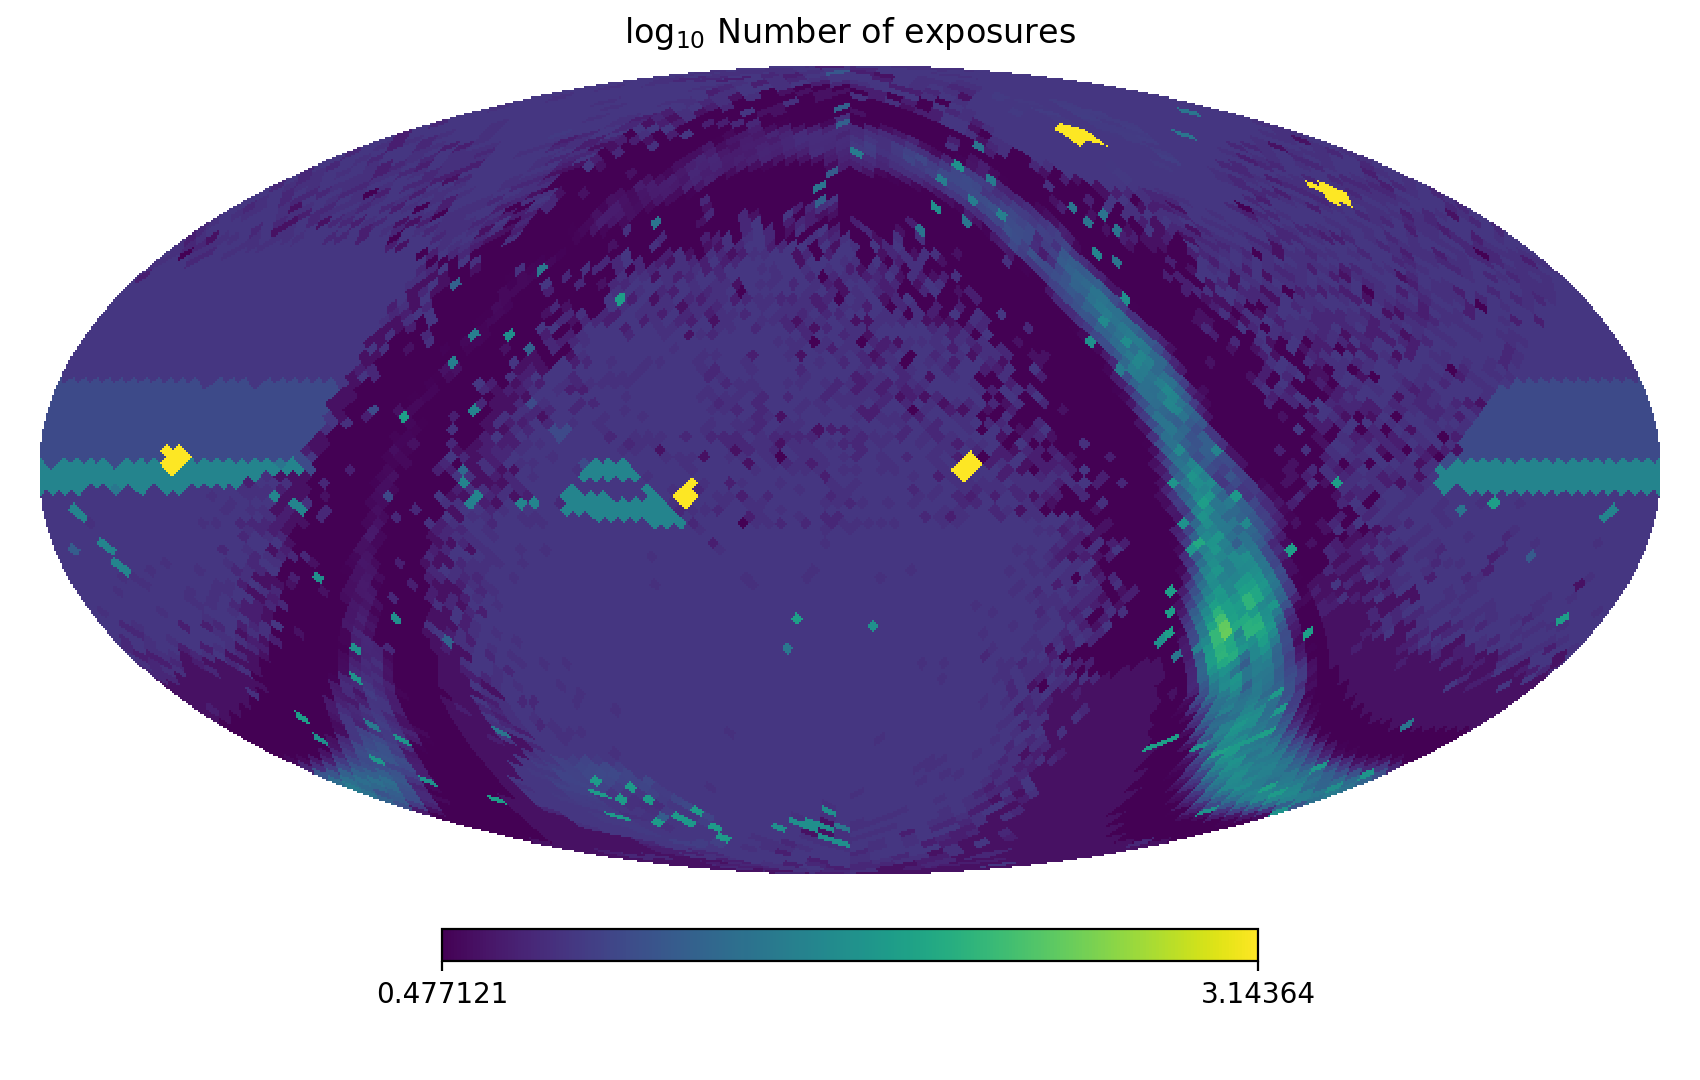

In [60]:
healpy.mollview(np.log10(epochs), title='log$_{10}$ Number of exposures')

If we add up all of these epochs, we can see that the necessary number of exposuress is somewhat bigger than we should expect. We expect about 30 exposures per clear night, and 200 clear nights per year, and 5 years, in two hemispheres. So that should be about 60,000 exposures. But that does not necessarily make this plan possible, of course.

In [62]:
print(epochs.sum() * healpy.nside2pixarea(nside, degrees=True) / a_tile)

95376.1738702


## Conclusions

First, we must standardize cadence types for each field. We need to require the teams to express their inputs in terms of a desired cadence at each field on the sky. Then we need to negotiate these cadences between the surveys at the field level.  It is all right if some targets have extended goal cadences, but they cannot drive the strategy because it makes things too complicated.

Here is a possible strategy. We define a field as a RA, Dec center. Each field can be observed with multiple tiles at multiple epochs. Create the following sets of fields:

 * Low-latitude fields (N): a dense covering
 * High-latitude fields (N): a sparse covering if necessary
 * RM fields (N)
 * RV fields (N)
 * Low-latitude fields (S): a dense covering
 * High-latitude fields (S): a sparse covering if necessary
 * RV fields (N)

Then assign cadences to each field according to the follwing rules based on where the target is.

 * Low-latitude fields (N): 1 exposure, N epochs as determined by target density
 * High-latitude fields (N); assigned depending on where they are
  * if in BHM MED: 4 exposures 12 dark epochs, else
  * if in BHM WIDE A: 4 exposures 3 dark epochs, else
  * if in BHM WIDE B: 4 exposures 2 dark epochs, else
  * if in BHM SPIDERS: (NTESS (<=8) - 4) exposures 1 epoch, 1 exposure 4 dark epochs, else
  * Regular: (NTESS (<=8) - 2) exposures 1 epoch, 1 exposure 2 epochs
 * BHM RM (N): 8 exposures 174 dark epochs
 * High-latitude fields (S)
  * Regular: (NTESS (<=8) - 2) exposures 1 epoch, 1 exposure 2 epochs 
  * SPIDERS: (NTESS (<=8) - 4) exposures 1 epoch, 1 exposure 4 dark epochs 
 * Low-latitude fields (S)
 * MWM RV: M exposures, N epochs as designated per field

As discussed elsewhere, use a dense covering in the low-latitude regions, and a sparse covering in ALL high-latitude regions.

Note that in this formulation we can later apply actual cadence requirements on a per field basis (but without complexifying more, not below that).